In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import skimage.io
import os
from tqdm import tqdm

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('using mps')
else:
    device = torch.device('cpu')
    print('Using cpu')

Using cuda


In [7]:
datadir = 'data/glands/'

In [8]:
# Make dataset class.
class GlandData(torch.utils.data.Dataset):
    '''
    Dataset which loads all images for training or testing
    '''

    def __init__(self, data_dir, im_id, margin_size=20):
        self.images = []
        self.labels = []
        for idx in im_id:
            self.images.append(torch.tensor(skimage.io.imread(f'{data_dir}{idx:03d}.png').transpose(2, 0, 1),
                                            dtype=torch.float32) / 255)
            label_im = skimage.io.imread(f'{data_dir}{idx:03d}_anno.png')[margin_size:-margin_size,
                       margin_size:-margin_size] / 255
            self.labels.append(torch.tensor(label_im, dtype=torch.int64))

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def __len__(self):
        return len(self.images)

In [9]:
gland_train_data = GlandData(datadir + 'train/train_', range(750))
gland_test_data = GlandData(datadir + 'test/test_', range(240))

In [10]:
# Function to display an image and its label
def show_image_and_label(dataset, index):
    image, label = dataset[index]
    image = image.permute(1, 2, 0).numpy()
    label = label.numpy()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(label, cmap='gray')
    ax[1].set_title('Label')

    plt.show()

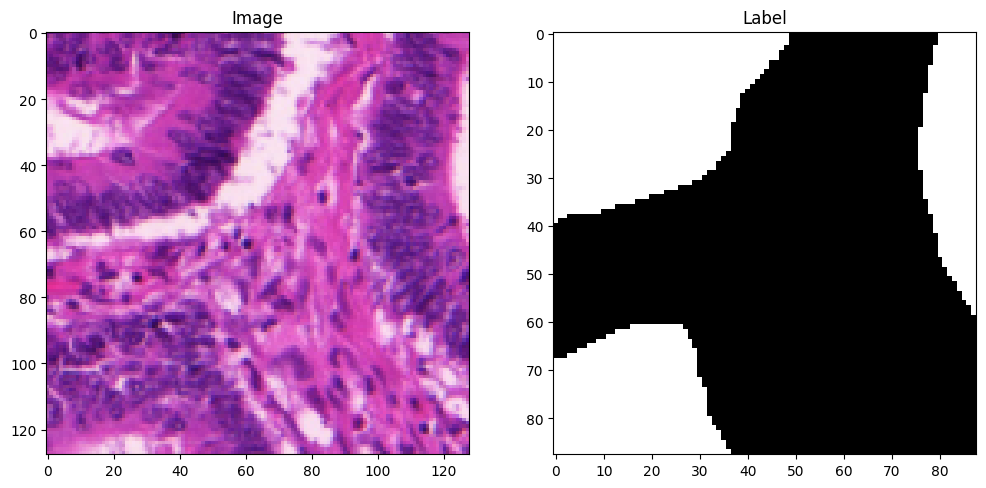

In [11]:
show_image_and_label(gland_train_data, 0)

In [12]:
class UNet128(torch.nn.Module):
    def __init__(self, out_channels=2):
        super().__init__()

        # Encoder (Contracting Path)
        self.conv1A = torch.nn.Conv2d(3, 8, 3)  # Input: 3 (RGB), Output: 8, Kernel: 3x3
        self.conv1B = torch.nn.Conv2d(8, 8, 3)  # Input: 8, Output: 8, Kernel: 3x3
        self.conv2A = torch.nn.Conv2d(8, 16, 3)  # Input: 8, Output: 16, Kernel: 3x3
        self.conv2B = torch.nn.Conv2d(16, 16, 3)  # Input: 16, Output: 16, Kernel: 3x3
        self.conv3A = torch.nn.Conv2d(16, 32, 3)  # Input: 16, Output: 32, Kernel: 3x3
        self.conv3B = torch.nn.Conv2d(32, 32, 3)  # Input: 32, Output: 32, Kernel: 3x3

        # Decoder (Expansive Path)
        self.conv4A = torch.nn.Conv2d(32, 16, 3)  # Input: 32, Output: 16, Kernel: 3x3
        self.conv4B = torch.nn.Conv2d(16, 16, 3)  # Input: 16, Output: 16, Kernel: 3x3
        self.conv5A = torch.nn.Conv2d(16, 8, 3)  # Input: 16, Output: 8, Kernel: 3x3
        self.conv5B = torch.nn.Conv2d(8, 8, 3)  # Input: 8, Output: 8, Kernel: 3x3
        self.convfinal = torch.nn.Conv2d(8, out_channels, 1)  # Final layer to get the desired output channels

        # Transposed Convolution for upsampling
        self.convtrans34 = torch.nn.ConvTranspose2d(32, 16, 2,
                                                    stride=2)  # Upsample: Input: 32, Output: 16, Kernel: 2x2, Stride: 2
        self.convtrans45 = torch.nn.ConvTranspose2d(16, 8, 2,
                                                    stride=2)  # Upsample: Input: 16, Output: 8, Kernel: 2x2, Stride: 2

        # Activation and Pooling
        self.relu = torch.nn.ReLU()  # ReLU activation function
        self.pool = torch.nn.MaxPool2d(2, 2)  # Max pooling: Kernel: 2x2, Stride: 2
        self.bottleneck = None  # Placeholder for the bottleneck layer

    def forward(self, x):
        # First Block
        x = self.conv1A(x)  # First convolution
        x = self.relu(x)  # Activation
        x = self.conv1B(x)  # Second convolution
        x = self.relu(x)  # Activation
        l1 = x  # Save the result for later (skip connection)
        x = self.pool(l1)  # Downsample (reduce size)

        # Second Block
        x = self.conv2A(x)  # Third convolution
        x = self.relu(x)  # Activation
        x = self.conv2B(x)  # Fourth convolution
        x = self.relu(x)  # Activation
        l2 = x  # Save the result for later (skip connection)
        x = self.pool(l2)  # Downsample

        # Third Block
        x = self.conv3A(x)  # Fifth convolution
        x = self.relu(x)  # Activation
        x = self.conv3B(x)  # Sixth convolution
        x = self.relu(x)  # Activation
        self.bottleneck = x  # Save this as the bottleneck (compressed info)

        # Upsampling Path (Decoder)
        # First Upsampling Block
        x = self.convtrans34(self.bottleneck)  # Upsample the bottleneck
        x = torch.cat([x, l2[:, :, 4:-4, 4:-4]], dim=1)  # Combine (concatenate) with second block output
        x = self.conv4A(x)  # Seventh convolution
        x = self.relu(x)  # Activation
        x = self.conv4B(x)  # Eighth convolution
        x = self.relu(x)  # Activation

        # Second Upsampling Block
        x = self.convtrans45(x)  # Upsample again
        x = torch.cat([x, l1[:, :, 16:-16, 16:-16]], dim=1)  # Combine with first block output
        x = self.conv5A(x)  # Ninth convolution
        x = self.relu(x)  # Activation
        x = self.conv5B(x)  # Tenth convolution
        x = self.relu(x)  # Activation

        # Final Output
        out = self.convfinal(x)  # Final convolution to get the output channels
        return out

In [13]:
def train_unet_128(train_data, model=None, lr=0.0001, nr_epochs=500, n_train_batch=10):
    if model is None:
        model = UNet128().to(device)

    #  Loaders for training and testing set
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=n_train_batch, shuffle=True, drop_last=True)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epoch_losses = []
    batch_losses = []

    # Train.
    for epoch in tqdm(range(nr_epochs)):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            image_batch, label_batch = batch
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)

            logits_batch = model(image_batch)

            optimizer.zero_grad()
            loss = loss_fn(logits_batch, label_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_losses.append(loss.item())
        epoch_losses.append(epoch_loss / len(train_loader))
        print(f'\rEpoch {epoch}/{nr_epochs}, loss {epoch_losses[-1]}', end='')
    return model, epoch_losses, batch_losses

In [14]:
def display_loss(epoch_losses, batch_losses):
    fig, ax = plt.subplots()

    # Plot batch losses
    ax.plot(np.linspace(0, len(epoch_losses), len(batch_losses)), batch_losses, lw=0.5, label='Batch Loss')

    # Plot epoch losses
    ax.plot(np.arange(len(epoch_losses)) + 0.5, epoch_losses, lw=2, label='Epoch Loss')

    # Set title and labels
    ax.set_title('Training Loss: Batch and Epoch Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    # Set y-axis limit
    ax.set_ylim(0, 1.5 * max(epoch_losses))

    # Add legend
    ax.legend()

    # Display the plot
    plt.show()

In [15]:
model, epoch_losses, batch_losses = train_unet_128(gland_train_data, nr_epochs=300)

  0%|▎                                                                                              | 1/300 [00:00<04:31,  1.10it/s]

Epoch 0/300, loss 0.6973731335004171

  1%|▋                                                                                              | 2/300 [00:01<02:56,  1.69it/s]

Epoch 1/300, loss 0.695616581439972

  1%|▉                                                                                              | 3/300 [00:01<02:20,  2.12it/s]

Epoch 2/300, loss 0.6942131996154786

  1%|█▎                                                                                             | 4/300 [00:01<02:04,  2.39it/s]

Epoch 3/300, loss 0.6932908829053243

  2%|█▌                                                                                             | 5/300 [00:02<01:54,  2.57it/s]

Epoch 4/300, loss 0.6923883398373921

  2%|█▉                                                                                             | 6/300 [00:02<01:48,  2.72it/s]

Epoch 5/300, loss 0.6914063930511475

  2%|██▏                                                                                            | 7/300 [00:02<01:45,  2.78it/s]

Epoch 6/300, loss 0.6899667437871297

  3%|██▌                                                                                            | 8/300 [00:03<01:42,  2.84it/s]

Epoch 7/300, loss 0.6874291602770487

  3%|██▊                                                                                            | 9/300 [00:03<01:40,  2.88it/s]

Epoch 8/300, loss 0.6799948422114054

  3%|███▏                                                                                          | 10/300 [00:03<01:40,  2.89it/s]

Epoch 9/300, loss 0.6706775259971619

  4%|███▍                                                                                          | 11/300 [00:04<01:39,  2.91it/s]

Epoch 10/300, loss 0.6646977599461873

  4%|███▊                                                                                          | 12/300 [00:04<01:37,  2.96it/s]

Epoch 11/300, loss 0.6612155667940776

  4%|████                                                                                          | 13/300 [00:04<01:37,  2.93it/s]

Epoch 12/300, loss 0.6568532156944275

  5%|████▍                                                                                         | 14/300 [00:05<01:36,  2.95it/s]

Epoch 13/300, loss 0.6547208611170451

  5%|████▋                                                                                         | 15/300 [00:05<01:36,  2.96it/s]

Epoch 14/300, loss 0.6545124681790669

  5%|█████                                                                                         | 16/300 [00:05<01:35,  2.97it/s]

Epoch 15/300, loss 0.648442002137502

  6%|█████▎                                                                                        | 17/300 [00:06<01:35,  2.98it/s]

Epoch 16/300, loss 0.6458982594807943

  6%|█████▋                                                                                        | 18/300 [00:06<01:35,  2.97it/s]

Epoch 17/300, loss 0.6451002216339111

  6%|█████▉                                                                                        | 19/300 [00:07<01:35,  2.94it/s]

Epoch 18/300, loss 0.6454470896720886

  7%|██████▎                                                                                       | 20/300 [00:07<01:36,  2.91it/s]

Epoch 19/300, loss 0.6448153257369995

  7%|██████▌                                                                                       | 21/300 [00:07<01:35,  2.92it/s]

Epoch 20/300, loss 0.6416579723358155

  7%|██████▉                                                                                       | 22/300 [00:08<01:34,  2.95it/s]

Epoch 21/300, loss 0.6345616594950358

  8%|███████▏                                                                                      | 23/300 [00:08<01:33,  2.97it/s]

Epoch 22/300, loss 0.6366049313545227

  8%|███████▌                                                                                      | 24/300 [00:08<01:33,  2.96it/s]

Epoch 23/300, loss 0.6291857989629109

  8%|███████▊                                                                                      | 25/300 [00:09<01:34,  2.93it/s]

Epoch 24/300, loss 0.628082214196523

  9%|████████▏                                                                                     | 26/300 [00:09<01:36,  2.85it/s]

Epoch 25/300, loss 0.6154354953765869

  9%|████████▍                                                                                     | 27/300 [00:09<01:35,  2.85it/s]

Epoch 26/300, loss 0.6093775987625122

  9%|████████▊                                                                                     | 28/300 [00:10<01:35,  2.85it/s]

Epoch 27/300, loss 0.612265764872233

 10%|█████████                                                                                     | 29/300 [00:10<01:34,  2.88it/s]

Epoch 28/300, loss 0.5957204421361287

 10%|█████████▍                                                                                    | 30/300 [00:10<01:32,  2.92it/s]

Epoch 29/300, loss 0.5987864383061727

 10%|█████████▋                                                                                    | 31/300 [00:11<01:31,  2.93it/s]

Epoch 30/300, loss 0.5757140294710795

 11%|██████████                                                                                    | 32/300 [00:11<01:31,  2.92it/s]

Epoch 31/300, loss 0.5733847065766653

 11%|██████████▎                                                                                   | 33/300 [00:11<01:31,  2.93it/s]

Epoch 32/300, loss 0.5619423770904541

 11%|██████████▋                                                                                   | 34/300 [00:12<01:31,  2.92it/s]

Epoch 33/300, loss 0.5639669422308604

 12%|██████████▉                                                                                   | 35/300 [00:12<01:32,  2.87it/s]

Epoch 34/300, loss 0.548552743991216

 12%|███████████▎                                                                                  | 36/300 [00:12<01:32,  2.85it/s]

Epoch 35/300, loss 0.5427405905723571

 12%|███████████▌                                                                                  | 37/300 [00:13<01:31,  2.87it/s]

Epoch 36/300, loss 0.5494994874795278

 13%|███████████▉                                                                                  | 38/300 [00:13<01:33,  2.80it/s]

Epoch 37/300, loss 0.5337266151110331

 13%|████████████▏                                                                                 | 39/300 [00:13<01:32,  2.81it/s]

Epoch 38/300, loss 0.529657962322235

 13%|████████████▌                                                                                 | 40/300 [00:14<01:32,  2.82it/s]

Epoch 39/300, loss 0.5316665522257487

 14%|████████████▊                                                                                 | 41/300 [00:14<01:31,  2.84it/s]

Epoch 40/300, loss 0.5366382881005605

 14%|█████████████▏                                                                                | 42/300 [00:14<01:29,  2.87it/s]

Epoch 41/300, loss 0.5305465761820475

 14%|█████████████▍                                                                                | 43/300 [00:15<01:29,  2.88it/s]

Epoch 42/300, loss 0.5254583863417307

 15%|█████████████▊                                                                                | 44/300 [00:15<01:27,  2.91it/s]

Epoch 43/300, loss 0.5225035035610199

 15%|██████████████                                                                                | 45/300 [00:16<01:27,  2.90it/s]

Epoch 44/300, loss 0.5225100878874461

 15%|██████████████▍                                                                               | 46/300 [00:16<01:27,  2.91it/s]

Epoch 45/300, loss 0.524958918094635

 16%|██████████████▋                                                                               | 47/300 [00:16<01:27,  2.91it/s]

Epoch 46/300, loss 0.5197221779823303

 16%|███████████████                                                                               | 48/300 [00:17<01:26,  2.91it/s]

Epoch 47/300, loss 0.5217937131722769

 16%|███████████████▎                                                                              | 49/300 [00:17<01:25,  2.94it/s]

Epoch 48/300, loss 0.5212726004918417

 17%|███████████████▋                                                                              | 50/300 [00:17<01:25,  2.92it/s]

Epoch 49/300, loss 0.518632162809372

 17%|███████████████▉                                                                              | 51/300 [00:18<01:23,  2.97it/s]

Epoch 50/300, loss 0.526535454193751

 17%|████████████████▎                                                                             | 52/300 [00:18<01:23,  2.99it/s]

Epoch 51/300, loss 0.5244513007005056

 18%|████████████████▌                                                                             | 53/300 [00:18<01:23,  2.95it/s]

Epoch 52/300, loss 0.5125603731473287

 18%|████████████████▉                                                                             | 54/300 [00:19<01:23,  2.96it/s]

Epoch 53/300, loss 0.5140184541543324

 18%|█████████████████▏                                                                            | 55/300 [00:19<01:24,  2.91it/s]

Epoch 54/300, loss 0.5115120800336203

 19%|█████████████████▌                                                                            | 56/300 [00:19<01:25,  2.87it/s]

Epoch 55/300, loss 0.510462084611257

 19%|█████████████████▊                                                                            | 57/300 [00:20<01:24,  2.87it/s]

Epoch 56/300, loss 0.5152034596602122

 19%|██████████████████▏                                                                           | 58/300 [00:20<01:25,  2.82it/s]

Epoch 57/300, loss 0.5140407001972198

 20%|██████████████████▍                                                                           | 59/300 [00:20<01:24,  2.84it/s]

Epoch 58/300, loss 0.5234231793880463

 20%|██████████████████▊                                                                           | 60/300 [00:21<01:23,  2.87it/s]

Epoch 59/300, loss 0.5228599135080974

 20%|███████████████████                                                                           | 61/300 [00:21<01:23,  2.87it/s]

Epoch 60/300, loss 0.5080378393332163

 21%|███████████████████▍                                                                          | 62/300 [00:21<01:23,  2.86it/s]

Epoch 61/300, loss 0.507787496248881

 21%|███████████████████▋                                                                          | 63/300 [00:22<01:22,  2.88it/s]

Epoch 62/300, loss 0.5171558252970377

 21%|████████████████████                                                                          | 64/300 [00:22<01:21,  2.90it/s]

Epoch 63/300, loss 0.5056581902503967

 22%|████████████████████▎                                                                         | 65/300 [00:22<01:21,  2.90it/s]

Epoch 64/300, loss 0.5098394012451172

 22%|████████████████████▋                                                                         | 66/300 [00:23<01:21,  2.88it/s]

Epoch 65/300, loss 0.5083126044273376

 22%|████████████████████▉                                                                         | 67/300 [00:23<01:20,  2.89it/s]

Epoch 66/300, loss 0.5039354638258616

 23%|█████████████████████▎                                                                        | 68/300 [00:23<01:19,  2.91it/s]

Epoch 67/300, loss 0.5082995597521464

 23%|█████████████████████▌                                                                        | 69/300 [00:24<01:20,  2.86it/s]

Epoch 68/300, loss 0.5057092428207397

 23%|█████████████████████▉                                                                        | 70/300 [00:24<01:21,  2.84it/s]

Epoch 69/300, loss 0.5093326532840728

 24%|██████████████████████▏                                                                       | 71/300 [00:25<01:21,  2.80it/s]

Epoch 70/300, loss 0.5087500027815501

 24%|██████████████████████▌                                                                       | 72/300 [00:25<01:20,  2.83it/s]

Epoch 71/300, loss 0.5022277553876241

 24%|██████████████████████▊                                                                       | 73/300 [00:25<01:19,  2.84it/s]

Epoch 72/300, loss 0.5089801553885142

 25%|███████████████████████▏                                                                      | 74/300 [00:26<01:18,  2.87it/s]

Epoch 73/300, loss 0.5027208403746287

 25%|███████████████████████▌                                                                      | 75/300 [00:26<01:17,  2.91it/s]

Epoch 74/300, loss 0.5047598528862

 25%|███████████████████████▊                                                                      | 76/300 [00:26<01:16,  2.94it/s]

Epoch 75/300, loss 0.49964093645413715

 26%|████████████████████████▏                                                                     | 77/300 [00:27<01:15,  2.95it/s]

Epoch 76/300, loss 0.49949071526527405

 26%|████████████████████████▍                                                                     | 78/300 [00:27<01:15,  2.92it/s]

Epoch 77/300, loss 0.5014312680562337

 26%|████████████████████████▊                                                                     | 79/300 [00:27<01:15,  2.94it/s]

Epoch 78/300, loss 0.5066390693187713

 27%|█████████████████████████                                                                     | 80/300 [00:28<01:14,  2.97it/s]

Epoch 79/300, loss 0.49814897020657856

 27%|█████████████████████████▍                                                                    | 81/300 [00:28<01:15,  2.91it/s]

Epoch 80/300, loss 0.5000424452622731

 27%|█████████████████████████▋                                                                    | 82/300 [00:28<01:15,  2.87it/s]

Epoch 81/300, loss 0.502521055539449

 28%|██████████████████████████                                                                    | 83/300 [00:29<01:16,  2.85it/s]

Epoch 82/300, loss 0.5013331985473632

 28%|██████████████████████████▎                                                                   | 84/300 [00:29<01:16,  2.83it/s]

Epoch 83/300, loss 0.5084899799029032

 28%|██████████████████████████▋                                                                   | 85/300 [00:29<01:16,  2.81it/s]

Epoch 84/300, loss 0.49838740785916646

 29%|██████████████████████████▉                                                                   | 86/300 [00:30<01:16,  2.80it/s]

Epoch 85/300, loss 0.4968000801404317

 29%|███████████████████████████▎                                                                  | 87/300 [00:30<01:16,  2.79it/s]

Epoch 86/300, loss 0.4975015381971995

 29%|███████████████████████████▌                                                                  | 88/300 [00:30<01:15,  2.81it/s]

Epoch 87/300, loss 0.5070678770542145

 30%|███████████████████████████▉                                                                  | 89/300 [00:31<01:14,  2.84it/s]

Epoch 88/300, loss 0.49726752638816835

 30%|████████████████████████████▏                                                                 | 90/300 [00:31<01:13,  2.87it/s]

Epoch 89/300, loss 0.5074820530414581

 30%|████████████████████████████▌                                                                 | 91/300 [00:31<01:12,  2.89it/s]

Epoch 90/300, loss 0.49453176458676656

 31%|████████████████████████████▊                                                                 | 92/300 [00:32<01:12,  2.89it/s]

Epoch 91/300, loss 0.49238194545110064

 31%|█████████████████████████████▏                                                                | 93/300 [00:32<01:11,  2.90it/s]

Epoch 92/300, loss 0.4997558569908142

 31%|█████████████████████████████▍                                                                | 94/300 [00:33<01:10,  2.91it/s]

Epoch 93/300, loss 0.4992341546217601

 32%|█████████████████████████████▊                                                                | 95/300 [00:33<01:11,  2.88it/s]

Epoch 94/300, loss 0.495566334327062

 32%|██████████████████████████████                                                                | 96/300 [00:33<01:10,  2.91it/s]

Epoch 95/300, loss 0.49247907598813373

 32%|██████████████████████████████▍                                                               | 97/300 [00:34<01:09,  2.93it/s]

Epoch 96/300, loss 0.4986669572194417

 33%|██████████████████████████████▋                                                               | 98/300 [00:34<01:08,  2.95it/s]

Epoch 97/300, loss 0.4947745418548584

 33%|███████████████████████████████                                                               | 99/300 [00:34<01:09,  2.88it/s]

Epoch 98/300, loss 0.49420552293459574

 33%|███████████████████████████████                                                              | 100/300 [00:35<01:09,  2.86it/s]

Epoch 99/300, loss 0.5143180743853251

 34%|███████████████████████████████▎                                                             | 101/300 [00:35<01:09,  2.85it/s]

Epoch 100/300, loss 0.4899002798398336

 34%|███████████████████████████████▌                                                             | 102/300 [00:35<01:09,  2.83it/s]

Epoch 101/300, loss 0.4960294044017792

 34%|███████████████████████████████▉                                                             | 103/300 [00:36<01:10,  2.80it/s]

Epoch 102/300, loss 0.5030192220211029

 35%|████████████████████████████████▏                                                            | 104/300 [00:36<01:10,  2.79it/s]

Epoch 103/300, loss 0.49300650993982953

 35%|████████████████████████████████▌                                                            | 105/300 [00:36<01:08,  2.85it/s]

Epoch 104/300, loss 0.48629891594250996

 35%|████████████████████████████████▊                                                            | 106/300 [00:37<01:06,  2.90it/s]

Epoch 105/300, loss 0.4871760133902232

 36%|█████████████████████████████████▏                                                           | 107/300 [00:37<01:06,  2.92it/s]

Epoch 106/300, loss 0.48716656923294066

 36%|█████████████████████████████████▍                                                           | 108/300 [00:37<01:06,  2.89it/s]

Epoch 107/300, loss 0.4948600912094116

 36%|█████████████████████████████████▊                                                           | 109/300 [00:38<01:05,  2.91it/s]

Epoch 108/300, loss 0.49177862962086993

 37%|██████████████████████████████████                                                           | 110/300 [00:38<01:04,  2.93it/s]

Epoch 109/300, loss 0.4851881345113119

 37%|██████████████████████████████████▍                                                          | 111/300 [00:38<01:04,  2.95it/s]

Epoch 110/300, loss 0.4930979629357656

 37%|██████████████████████████████████▋                                                          | 112/300 [00:39<01:03,  2.96it/s]

Epoch 111/300, loss 0.48984513282775877

 38%|███████████████████████████████████                                                          | 113/300 [00:39<01:02,  2.98it/s]

Epoch 112/300, loss 0.48848153789838156

 38%|███████████████████████████████████▎                                                         | 114/300 [00:39<01:02,  2.98it/s]

Epoch 113/300, loss 0.4877315445741018

 38%|███████████████████████████████████▋                                                         | 115/300 [00:40<01:01,  2.99it/s]

Epoch 114/300, loss 0.48391321341196697

 39%|███████████████████████████████████▉                                                         | 116/300 [00:40<01:01,  3.01it/s]

Epoch 115/300, loss 0.4877051198482513

 39%|████████████████████████████████████▎                                                        | 117/300 [00:40<01:00,  3.01it/s]

Epoch 116/300, loss 0.4844956604639689

 39%|████████████████████████████████████▌                                                        | 118/300 [00:41<01:00,  3.02it/s]

Epoch 117/300, loss 0.48726775725682575

 40%|████████████████████████████████████▉                                                        | 119/300 [00:41<00:59,  3.02it/s]

Epoch 118/300, loss 0.48710011879603066

 40%|█████████████████████████████████████▏                                                       | 120/300 [00:41<01:01,  2.94it/s]

Epoch 119/300, loss 0.48620117545127867

 40%|█████████████████████████████████████▌                                                       | 121/300 [00:42<01:01,  2.91it/s]

Epoch 120/300, loss 0.48733556350072227

 41%|█████████████████████████████████████▊                                                       | 122/300 [00:42<01:01,  2.89it/s]

Epoch 121/300, loss 0.4794694534937541

 41%|██████████████████████████████████████▏                                                      | 123/300 [00:42<01:01,  2.86it/s]

Epoch 122/300, loss 0.49004404425621034

 41%|██████████████████████████████████████▍                                                      | 124/300 [00:43<01:01,  2.88it/s]

Epoch 123/300, loss 0.4833215037981669

 42%|██████████████████████████████████████▊                                                      | 125/300 [00:43<01:00,  2.88it/s]

Epoch 124/300, loss 0.48103667338689166

 42%|███████████████████████████████████████                                                      | 126/300 [00:44<01:01,  2.85it/s]

Epoch 125/300, loss 0.4906833827495575

 42%|███████████████████████████████████████▎                                                     | 127/300 [00:44<01:00,  2.87it/s]

Epoch 126/300, loss 0.48040538787841797

 43%|███████████████████████████████████████▋                                                     | 128/300 [00:44<00:59,  2.87it/s]

Epoch 127/300, loss 0.48981528242429095

 43%|███████████████████████████████████████▉                                                     | 129/300 [00:45<00:58,  2.91it/s]

Epoch 128/300, loss 0.47923643708229063

 43%|████████████████████████████████████████▎                                                    | 130/300 [00:45<00:58,  2.89it/s]

Epoch 129/300, loss 0.4974333870410919

 44%|████████████████████████████████████████▌                                                    | 131/300 [00:45<00:58,  2.90it/s]

Epoch 130/300, loss 0.48276305039723716

 44%|████████████████████████████████████████▉                                                    | 132/300 [00:46<00:57,  2.90it/s]

Epoch 131/300, loss 0.484612189133962

 44%|█████████████████████████████████████████▏                                                   | 133/300 [00:46<00:57,  2.92it/s]

Epoch 132/300, loss 0.4749098992347717

 45%|█████████████████████████████████████████▌                                                   | 134/300 [00:46<00:57,  2.89it/s]

Epoch 133/300, loss 0.48286524971326195

 45%|█████████████████████████████████████████▊                                                   | 135/300 [00:47<00:57,  2.89it/s]

Epoch 134/300, loss 0.4787345282236735

 45%|██████████████████████████████████████████▏                                                  | 136/300 [00:47<00:57,  2.83it/s]

Epoch 135/300, loss 0.4818974276383718

 46%|██████████████████████████████████████████▍                                                  | 137/300 [00:47<00:57,  2.84it/s]

Epoch 136/300, loss 0.48205932100613913

 46%|██████████████████████████████████████████▊                                                  | 138/300 [00:48<00:56,  2.87it/s]

Epoch 137/300, loss 0.4853063786029816

 46%|███████████████████████████████████████████                                                  | 139/300 [00:48<00:56,  2.86it/s]

Epoch 138/300, loss 0.4782494088013967

 47%|███████████████████████████████████████████▍                                                 | 140/300 [00:48<00:55,  2.90it/s]

Epoch 139/300, loss 0.48205134868621824

 47%|███████████████████████████████████████████▋                                                 | 141/300 [00:49<00:54,  2.92it/s]

Epoch 140/300, loss 0.47933651208877565

 47%|████████████████████████████████████████████                                                 | 142/300 [00:49<00:53,  2.95it/s]

Epoch 141/300, loss 0.47876128792762757

 48%|████████████████████████████████████████████▎                                                | 143/300 [00:49<00:53,  2.96it/s]

Epoch 142/300, loss 0.47962936758995056

 48%|████████████████████████████████████████████▋                                                | 144/300 [00:50<00:52,  2.97it/s]

Epoch 143/300, loss 0.47537525177001955

 48%|████████████████████████████████████████████▉                                                | 145/300 [00:50<00:51,  2.98it/s]

Epoch 144/300, loss 0.4778069523970286

 49%|█████████████████████████████████████████████▎                                               | 146/300 [00:50<00:51,  2.96it/s]

Epoch 145/300, loss 0.48749462723731996

 49%|█████████████████████████████████████████████▌                                               | 147/300 [00:51<00:51,  2.98it/s]

Epoch 146/300, loss 0.4716796843210856

 49%|█████████████████████████████████████████████▉                                               | 148/300 [00:51<00:50,  2.99it/s]

Epoch 147/300, loss 0.4756261642773946

 50%|██████████████████████████████████████████████▏                                              | 149/300 [00:51<00:51,  2.96it/s]

Epoch 148/300, loss 0.47192071119944257

 50%|██████████████████████████████████████████████▌                                              | 150/300 [00:52<00:50,  2.97it/s]

Epoch 149/300, loss 0.46958495100339254

 50%|██████████████████████████████████████████████▊                                              | 151/300 [00:52<00:49,  2.98it/s]

Epoch 150/300, loss 0.47978753566741944

 51%|███████████████████████████████████████████████                                              | 152/300 [00:52<00:50,  2.96it/s]

Epoch 151/300, loss 0.4776774299144745

 51%|███████████████████████████████████████████████▍                                             | 153/300 [00:53<00:49,  2.96it/s]

Epoch 152/300, loss 0.4722919360796611

 51%|███████████████████████████████████████████████▋                                             | 154/300 [00:53<00:49,  2.94it/s]

Epoch 153/300, loss 0.4766689383983612

 52%|████████████████████████████████████████████████                                             | 155/300 [00:53<00:49,  2.93it/s]

Epoch 154/300, loss 0.47656126459439596

 52%|████████████████████████████████████████████████▎                                            | 156/300 [00:54<00:48,  2.95it/s]

Epoch 155/300, loss 0.47703108986218773

 52%|████████████████████████████████████████████████▋                                            | 157/300 [00:54<00:48,  2.93it/s]

Epoch 156/300, loss 0.47138468503952025

 53%|████████████████████████████████████████████████▉                                            | 158/300 [00:54<00:49,  2.89it/s]

Epoch 157/300, loss 0.46941909432411194

 53%|█████████████████████████████████████████████████▎                                           | 159/300 [00:55<00:48,  2.89it/s]

Epoch 158/300, loss 0.472714778582255

 53%|█████████████████████████████████████████████████▌                                           | 160/300 [00:55<00:47,  2.92it/s]

Epoch 159/300, loss 0.4697113533814748

 54%|█████████████████████████████████████████████████▉                                           | 161/300 [00:55<00:47,  2.94it/s]

Epoch 160/300, loss 0.4731474272410075

 54%|██████████████████████████████████████████████████▏                                          | 162/300 [00:56<00:46,  2.95it/s]

Epoch 161/300, loss 0.47070040663083396

 54%|██████████████████████████████████████████████████▌                                          | 163/300 [00:56<00:46,  2.97it/s]

Epoch 162/300, loss 0.4659156370162964

 55%|██████████████████████████████████████████████████▊                                          | 164/300 [00:56<00:46,  2.91it/s]

Epoch 163/300, loss 0.4687801210085551

 55%|███████████████████████████████████████████████████▏                                         | 165/300 [00:57<00:46,  2.87it/s]

Epoch 164/300, loss 0.46417712926864624

 55%|███████████████████████████████████████████████████▍                                         | 166/300 [00:57<00:46,  2.85it/s]

Epoch 165/300, loss 0.4650787623723348

 56%|███████████████████████████████████████████████████▊                                         | 167/300 [00:58<00:46,  2.85it/s]

Epoch 166/300, loss 0.4726712354024251

 56%|████████████████████████████████████████████████████                                         | 168/300 [00:58<00:46,  2.83it/s]

Epoch 167/300, loss 0.4685457185904185

 56%|████████████████████████████████████████████████████▍                                        | 169/300 [00:58<00:46,  2.82it/s]

Epoch 168/300, loss 0.4615929396947225

 57%|████████████████████████████████████████████████████▋                                        | 170/300 [00:59<00:46,  2.82it/s]

Epoch 169/300, loss 0.48156667431195577

 57%|█████████████████████████████████████████████████████                                        | 171/300 [00:59<00:45,  2.86it/s]

Epoch 170/300, loss 0.47280237873395287

 57%|█████████████████████████████████████████████████████▎                                       | 172/300 [00:59<00:44,  2.88it/s]

Epoch 171/300, loss 0.46432713747024534

 58%|█████████████████████████████████████████████████████▋                                       | 173/300 [01:00<00:44,  2.88it/s]

Epoch 172/300, loss 0.478313893477122

 58%|█████████████████████████████████████████████████████▉                                       | 174/300 [01:00<00:43,  2.89it/s]

Epoch 173/300, loss 0.4645368599891663

 58%|██████████████████████████████████████████████████████▎                                      | 175/300 [01:00<00:42,  2.91it/s]

Epoch 174/300, loss 0.4640039443969727

 59%|██████████████████████████████████████████████████████▌                                      | 176/300 [01:01<00:42,  2.93it/s]

Epoch 175/300, loss 0.46901201605796816

 59%|██████████████████████████████████████████████████████▊                                      | 177/300 [01:01<00:42,  2.93it/s]

Epoch 176/300, loss 0.46651221831639605

 59%|███████████████████████████████████████████████████████▏                                     | 178/300 [01:01<00:42,  2.90it/s]

Epoch 177/300, loss 0.46190317352612814

 60%|███████████████████████████████████████████████████████▍                                     | 179/300 [01:02<00:42,  2.88it/s]

Epoch 178/300, loss 0.46417415142059326

 60%|███████████████████████████████████████████████████████▊                                     | 180/300 [01:02<00:41,  2.87it/s]

Epoch 179/300, loss 0.4690114219983419

 60%|████████████████████████████████████████████████████████                                     | 181/300 [01:02<00:41,  2.85it/s]

Epoch 180/300, loss 0.4694137767950694

 61%|████████████████████████████████████████████████████████▍                                    | 182/300 [01:03<00:41,  2.82it/s]

Epoch 181/300, loss 0.4690220057964325

 61%|████████████████████████████████████████████████████████▋                                    | 183/300 [01:03<00:41,  2.80it/s]

Epoch 182/300, loss 0.46096039573351544

 61%|█████████████████████████████████████████████████████████                                    | 184/300 [01:04<00:41,  2.79it/s]

Epoch 183/300, loss 0.4602236334482829

 62%|█████████████████████████████████████████████████████████▎                                   | 185/300 [01:04<00:41,  2.77it/s]

Epoch 184/300, loss 0.46149481495221456

 62%|█████████████████████████████████████████████████████████▋                                   | 186/300 [01:04<00:41,  2.76it/s]

Epoch 185/300, loss 0.45888329346974693

 62%|█████████████████████████████████████████████████████████▉                                   | 187/300 [01:05<00:40,  2.80it/s]

Epoch 186/300, loss 0.45549219846725464

 63%|██████████████████████████████████████████████████████████▎                                  | 188/300 [01:05<00:39,  2.81it/s]

Epoch 187/300, loss 0.45431187232335407

 63%|██████████████████████████████████████████████████████████▌                                  | 189/300 [01:05<00:39,  2.84it/s]

Epoch 188/300, loss 0.46404274702072146

 63%|██████████████████████████████████████████████████████████▉                                  | 190/300 [01:06<00:38,  2.85it/s]

Epoch 189/300, loss 0.46036149899164835

 64%|███████████████████████████████████████████████████████████▏                                 | 191/300 [01:06<00:38,  2.86it/s]

Epoch 190/300, loss 0.4541661302248637

 64%|███████████████████████████████████████████████████████████▌                                 | 192/300 [01:06<00:37,  2.87it/s]

Epoch 191/300, loss 0.4542482654253642

 64%|███████████████████████████████████████████████████████████▊                                 | 193/300 [01:07<00:37,  2.87it/s]

Epoch 192/300, loss 0.45505183895428974

 65%|████████████████████████████████████████████████████████████▏                                | 194/300 [01:07<00:36,  2.90it/s]

Epoch 193/300, loss 0.4557343029975891

 65%|████████████████████████████████████████████████████████████▍                                | 195/300 [01:07<00:36,  2.91it/s]

Epoch 194/300, loss 0.45675336440404257

 65%|████████████████████████████████████████████████████████████▊                                | 196/300 [01:08<00:36,  2.89it/s]

Epoch 195/300, loss 0.459750056664149

 66%|█████████████████████████████████████████████████████████████                                | 197/300 [01:08<00:35,  2.90it/s]

Epoch 196/300, loss 0.4630036648114522

 66%|█████████████████████████████████████████████████████████████▍                               | 198/300 [01:08<00:34,  2.92it/s]

Epoch 197/300, loss 0.46204928517341615

 66%|█████████████████████████████████████████████████████████████▋                               | 199/300 [01:09<00:34,  2.93it/s]

Epoch 198/300, loss 0.45232102314631145

 67%|██████████████████████████████████████████████████████████████                               | 200/300 [01:09<00:33,  2.95it/s]

Epoch 199/300, loss 0.46213270743687945

 67%|██████████████████████████████████████████████████████████████▎                              | 201/300 [01:09<00:34,  2.91it/s]

Epoch 200/300, loss 0.4514193681875865

 67%|██████████████████████████████████████████████████████████████▌                              | 202/300 [01:10<00:34,  2.88it/s]

Epoch 201/300, loss 0.45600893219312033

 68%|██████████████████████████████████████████████████████████████▉                              | 203/300 [01:10<00:33,  2.86it/s]

Epoch 202/300, loss 0.45916553656260173

 68%|███████████████████████████████████████████████████████████████▏                             | 204/300 [01:10<00:33,  2.86it/s]

Epoch 203/300, loss 0.45300209840138755

 68%|███████████████████████████████████████████████████████████████▌                             | 205/300 [01:11<00:33,  2.87it/s]

Epoch 204/300, loss 0.4492623202006022

 69%|███████████████████████████████████████████████████████████████▊                             | 206/300 [01:11<00:33,  2.85it/s]

Epoch 205/300, loss 0.4526375599702199

 69%|████████████████████████████████████████████████████████████████▏                            | 207/300 [01:12<00:32,  2.88it/s]

Epoch 206/300, loss 0.4578990213076274

 69%|████████████████████████████████████████████████████████████████▍                            | 208/300 [01:12<00:31,  2.90it/s]

Epoch 207/300, loss 0.4525874098141988

 70%|████████████████████████████████████████████████████████████████▊                            | 209/300 [01:12<00:31,  2.93it/s]

Epoch 208/300, loss 0.44880802909533185

 70%|█████████████████████████████████████████████████████████████████                            | 210/300 [01:13<00:30,  2.91it/s]

Epoch 209/300, loss 0.45034180839856464

 70%|█████████████████████████████████████████████████████████████████▍                           | 211/300 [01:13<00:30,  2.91it/s]

Epoch 210/300, loss 0.44803438266118367

 71%|█████████████████████████████████████████████████████████████████▋                           | 212/300 [01:13<00:30,  2.93it/s]

Epoch 211/300, loss 0.45415423115094505

 71%|██████████████████████████████████████████████████████████████████                           | 213/300 [01:14<00:29,  2.93it/s]

Epoch 212/300, loss 0.45135294715563457

 71%|██████████████████████████████████████████████████████████████████▎                          | 214/300 [01:14<00:29,  2.91it/s]

Epoch 213/300, loss 0.4484256716569265

 72%|██████████████████████████████████████████████████████████████████▋                          | 215/300 [01:14<00:29,  2.88it/s]

Epoch 214/300, loss 0.4446844760576884

 72%|██████████████████████████████████████████████████████████████████▉                          | 216/300 [01:15<00:28,  2.90it/s]

Epoch 215/300, loss 0.4558780360221863

 72%|███████████████████████████████████████████████████████████████████▎                         | 217/300 [01:15<00:28,  2.88it/s]

Epoch 216/300, loss 0.45102386077245077

 73%|███████████████████████████████████████████████████████████████████▌                         | 218/300 [01:15<00:28,  2.89it/s]

Epoch 217/300, loss 0.45026623368263247

 73%|███████████████████████████████████████████████████████████████████▉                         | 219/300 [01:16<00:28,  2.87it/s]

Epoch 218/300, loss 0.4507028249899546

 73%|████████████████████████████████████████████████████████████████████▏                        | 220/300 [01:16<00:27,  2.87it/s]

Epoch 219/300, loss 0.44476381500562034

 74%|████████████████████████████████████████████████████████████████████▌                        | 221/300 [01:16<00:27,  2.87it/s]

Epoch 220/300, loss 0.44794782439867653

 74%|████████████████████████████████████████████████████████████████████▊                        | 222/300 [01:17<00:27,  2.85it/s]

Epoch 221/300, loss 0.44162845889727276

 74%|█████████████████████████████████████████████████████████████████████▏                       | 223/300 [01:17<00:27,  2.82it/s]

Epoch 222/300, loss 0.4463399144013723

 75%|█████████████████████████████████████████████████████████████████████▍                       | 224/300 [01:17<00:27,  2.79it/s]

Epoch 223/300, loss 0.44536503036816916

 75%|█████████████████████████████████████████████████████████████████████▊                       | 225/300 [01:18<00:26,  2.81it/s]

Epoch 224/300, loss 0.4441277511914571

 75%|██████████████████████████████████████████████████████████████████████                       | 226/300 [01:18<00:26,  2.84it/s]

Epoch 225/300, loss 0.45791232188542685

 76%|██████████████████████████████████████████████████████████████████████▎                      | 227/300 [01:18<00:25,  2.86it/s]

Epoch 226/300, loss 0.4508274340629578

 76%|██████████████████████████████████████████████████████████████████████▋                      | 228/300 [01:19<00:24,  2.89it/s]

Epoch 227/300, loss 0.4572304975986481

 76%|██████████████████████████████████████████████████████████████████████▉                      | 229/300 [01:19<00:24,  2.91it/s]

Epoch 228/300, loss 0.4454494345188141

 77%|███████████████████████████████████████████████████████████████████████▎                     | 230/300 [01:19<00:23,  2.93it/s]

Epoch 229/300, loss 0.4396435832977295

 77%|███████████████████████████████████████████████████████████████████████▌                     | 231/300 [01:20<00:23,  2.94it/s]

Epoch 230/300, loss 0.43797024031480153

 77%|███████████████████████████████████████████████████████████████████████▉                     | 232/300 [01:20<00:23,  2.94it/s]

Epoch 231/300, loss 0.4482307457923889

 78%|████████████████████████████████████████████████████████████████████████▏                    | 233/300 [01:21<00:22,  2.94it/s]

Epoch 232/300, loss 0.45090240478515625

 78%|████████████████████████████████████████████████████████████████████████▌                    | 234/300 [01:21<00:22,  2.95it/s]

Epoch 233/300, loss 0.4394850158691406

 78%|████████████████████████████████████████████████████████████████████████▊                    | 235/300 [01:21<00:21,  2.96it/s]

Epoch 234/300, loss 0.448919917345047

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 236/300 [01:22<00:21,  2.95it/s]

Epoch 235/300, loss 0.44109328945477805

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 237/300 [01:22<00:21,  2.95it/s]

Epoch 236/300, loss 0.4384336996078491

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 238/300 [01:22<00:21,  2.92it/s]

Epoch 237/300, loss 0.4359928727149963

 80%|██████████████████████████████████████████████████████████████████████████                   | 239/300 [01:23<00:20,  2.92it/s]

Epoch 238/300, loss 0.43660790046056114

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 240/300 [01:23<00:20,  2.94it/s]

Epoch 239/300, loss 0.4408247371514638

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 241/300 [01:23<00:20,  2.94it/s]

Epoch 240/300, loss 0.4337133820851644

 81%|███████████████████████████████████████████████████████████████████████████                  | 242/300 [01:24<00:19,  2.94it/s]

Epoch 241/300, loss 0.43867302338282266

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 243/300 [01:24<00:19,  2.93it/s]

Epoch 242/300, loss 0.4418151430288951

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 244/300 [01:24<00:18,  2.95it/s]

Epoch 243/300, loss 0.43613526463508606

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 245/300 [01:25<00:18,  2.93it/s]

Epoch 244/300, loss 0.43992949883143107

 82%|████████████████████████████████████████████████████████████████████████████▎                | 246/300 [01:25<00:18,  2.89it/s]

Epoch 245/300, loss 0.43038546681404116

 82%|████████████████████████████████████████████████████████████████████████████▌                | 247/300 [01:25<00:18,  2.88it/s]

Epoch 246/300, loss 0.4414768385887146

 83%|████████████████████████████████████████████████████████████████████████████▉                | 248/300 [01:26<00:18,  2.89it/s]

Epoch 247/300, loss 0.4335530177752177

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 249/300 [01:26<00:17,  2.90it/s]

Epoch 248/300, loss 0.44166220784187316

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 250/300 [01:26<00:17,  2.91it/s]

Epoch 249/300, loss 0.4320613622665405

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 251/300 [01:27<00:16,  2.92it/s]

Epoch 250/300, loss 0.43079201102256776

 84%|██████████████████████████████████████████████████████████████████████████████               | 252/300 [01:27<00:16,  2.86it/s]

Epoch 251/300, loss 0.43654818574587506

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 253/300 [01:27<00:16,  2.86it/s]

Epoch 252/300, loss 0.42981771429379784

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 254/300 [01:28<00:16,  2.87it/s]

Epoch 253/300, loss 0.43795708934466043

 85%|███████████████████████████████████████████████████████████████████████████████              | 255/300 [01:28<00:15,  2.88it/s]

Epoch 254/300, loss 0.44072188138961793

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 256/300 [01:28<00:15,  2.88it/s]

Epoch 255/300, loss 0.424169237613678

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 257/300 [01:29<00:15,  2.85it/s]

Epoch 256/300, loss 0.4342656286557515

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 258/300 [01:29<00:14,  2.83it/s]

Epoch 257/300, loss 0.4360662659009298

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 259/300 [01:29<00:14,  2.82it/s]

Epoch 258/300, loss 0.4294758570194244

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 260/300 [01:30<00:14,  2.74it/s]

Epoch 259/300, loss 0.4289776434501012

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 261/300 [01:30<00:14,  2.69it/s]

Epoch 260/300, loss 0.42757362802823384

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 262/300 [01:31<00:14,  2.67it/s]

Epoch 261/300, loss 0.42965893308321634

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 263/300 [01:31<00:13,  2.67it/s]

Epoch 262/300, loss 0.426758728424708

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 264/300 [01:31<00:13,  2.71it/s]

Epoch 263/300, loss 0.42906318545341493

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 265/300 [01:32<00:12,  2.75it/s]

Epoch 264/300, loss 0.42994131684303283

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 266/300 [01:32<00:12,  2.71it/s]

Epoch 265/300, loss 0.42195920904477435

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 267/300 [01:32<00:12,  2.70it/s]

Epoch 266/300, loss 0.4310565829277039

 89%|███████████████████████████████████████████████████████████████████████████████████          | 268/300 [01:33<00:11,  2.73it/s]

Epoch 267/300, loss 0.4231877911090851

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 269/300 [01:33<00:11,  2.72it/s]

Epoch 268/300, loss 0.42591389377911887

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 270/300 [01:34<00:10,  2.77it/s]

Epoch 269/300, loss 0.4318024738629659

 90%|████████████████████████████████████████████████████████████████████████████████████         | 271/300 [01:34<00:10,  2.81it/s]

Epoch 270/300, loss 0.4282415862878164

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 272/300 [01:34<00:09,  2.85it/s]

Epoch 271/300, loss 0.42488920092582705

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 273/300 [01:35<00:09,  2.84it/s]

Epoch 272/300, loss 0.41930341919263203

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 274/300 [01:35<00:09,  2.87it/s]

Epoch 273/300, loss 0.42092354615529376

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 275/300 [01:35<00:08,  2.88it/s]

Epoch 274/300, loss 0.4220982567469279

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 276/300 [01:36<00:08,  2.90it/s]

Epoch 275/300, loss 0.42543049653371173

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 277/300 [01:36<00:07,  2.90it/s]

Epoch 276/300, loss 0.4199626710017522

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 278/300 [01:36<00:07,  2.86it/s]

Epoch 277/300, loss 0.4299438714981079

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 279/300 [01:37<00:07,  2.85it/s]

Epoch 278/300, loss 0.4208352470397949

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 280/300 [01:37<00:06,  2.87it/s]

Epoch 279/300, loss 0.43199720342954

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 281/300 [01:37<00:06,  2.85it/s]

Epoch 280/300, loss 0.42648829221725465

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 282/300 [01:38<00:06,  2.85it/s]

Epoch 281/300, loss 0.4239932624499003

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 283/300 [01:38<00:06,  2.83it/s]

Epoch 282/300, loss 0.4212802843252818

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 284/300 [01:38<00:05,  2.86it/s]

Epoch 283/300, loss 0.4272658960024516

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 285/300 [01:39<00:05,  2.88it/s]

Epoch 284/300, loss 0.41801018714904786

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 286/300 [01:39<00:04,  2.91it/s]

Epoch 285/300, loss 0.42328782300154366

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 287/300 [01:39<00:04,  2.92it/s]

Epoch 286/300, loss 0.42061927596728005

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 288/300 [01:40<00:04,  2.91it/s]

Epoch 287/300, loss 0.42267422199249266

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 289/300 [01:40<00:03,  2.87it/s]

Epoch 288/300, loss 0.4231515185038249

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 290/300 [01:40<00:03,  2.88it/s]

Epoch 289/300, loss 0.4203209968407949

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 291/300 [01:41<00:03,  2.85it/s]

Epoch 290/300, loss 0.419012234210968

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 292/300 [01:41<00:02,  2.85it/s]

Epoch 291/300, loss 0.4297618488470713

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 293/300 [01:42<00:02,  2.88it/s]

Epoch 292/300, loss 0.4232076307137807

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 294/300 [01:42<00:02,  2.90it/s]

Epoch 293/300, loss 0.4186320545276006

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 295/300 [01:42<00:01,  2.87it/s]

Epoch 294/300, loss 0.4137585934003194

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 296/300 [01:43<00:01,  2.87it/s]

Epoch 295/300, loss 0.41956095894177753

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 297/300 [01:43<00:01,  2.85it/s]

Epoch 296/300, loss 0.4149984296162923

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 298/300 [01:43<00:00,  2.82it/s]

Epoch 297/300, loss 0.4252902070681254

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 299/300 [01:44<00:00,  2.80it/s]

Epoch 298/300, loss 0.4121623158454895

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:44<00:00,  2.87it/s]

Epoch 299/300, loss 0.4097772673765818

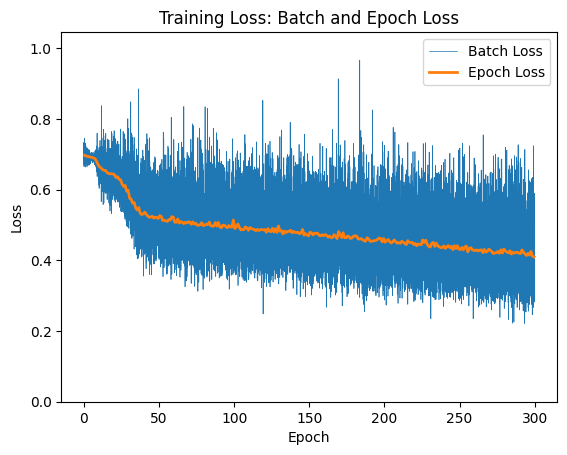

In [16]:
display_loss(epoch_losses, batch_losses)

In [17]:
if not os.path.isdir('results'):
    os.mkdir('results')
torch.save(model, 'results/model_300.pt')

In [18]:
model = torch.load('results/model_300.pt')
model.eval()

UNet128(
  (conv1A): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv1B): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2A): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2B): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3A): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3B): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4A): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4B): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5A): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv5B): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (convfinal): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  (convtrans34): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (convtrans45): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

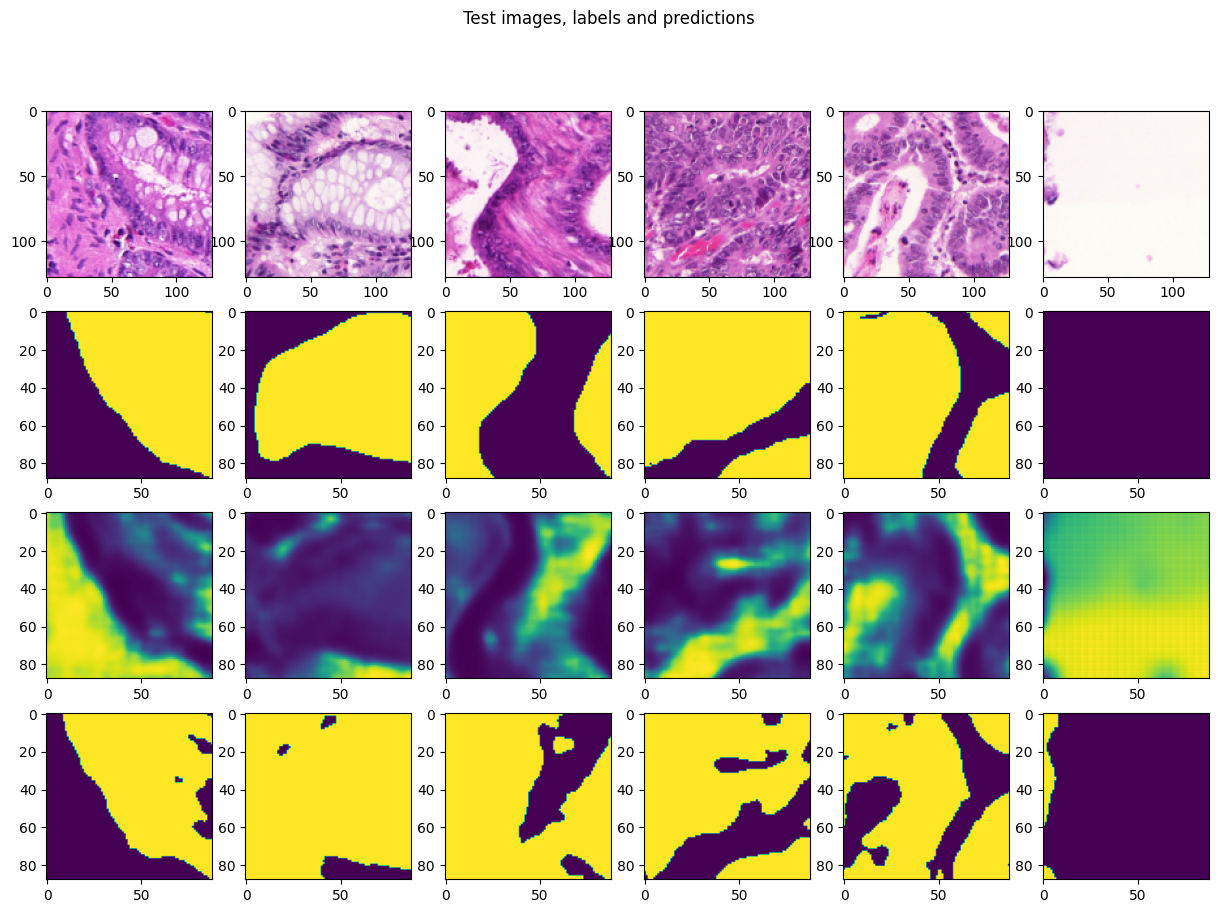

In [19]:
# Show predictions for a few images from the test set.
idxs = [19, 50, 61, 100, 151, 233]
fig, ax = plt.subplots(4, len(idxs), figsize=(15, 10))
for n, idx in enumerate(idxs):
    im_val, lb_val = gland_test_data[idx]
    with torch.no_grad():
        lgt_val = model(im_val.unsqueeze(0).to(device))
    prob_val = torch.nn.functional.softmax(lgt_val, dim=1)

    ax[0, n].imshow(im_val.permute(1, 2, 0))
    ax[1, n].imshow(lb_val)
    prob = prob_val[0].cpu().detach().numpy()
    seg = prob.argmax(axis=0)
    ax[2, n].imshow(prob[0])
    ax[3, n].imshow(seg)
fig.suptitle('Test images, labels and predictions')
plt.show()

In [20]:
def test_image_stat(test_data, model, n_test_batch=20):
    # Initialize DataLoader for the test dataset with the specified batch size
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_test_batch)
    # Define the loss function (Cross Entropy Loss)
    loss_fn = torch.nn.CrossEntropyLoss()
    # Initialize variables for total loss, Dice coefficient, accuracy, and probabilities
    total_loss = 0
    dice = []
    acc = []
    prob = []
    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for batch in test_loader:
            image_batch, label_batch_in = batch  # Unpack the data
            image_batch = image_batch.to(device)  # Move image batch to device (CPU or GPU)
            label_batch = label_batch_in.to(device)  # Move label batch to device
            
            # Forward pass: compute logits
            logits_batch = model(image_batch)
            
            # Compute and accumulate the loss
            total_loss += loss_fn(logits_batch, label_batch).item()
            
            # Move labels to CPU and convert to numpy array
            l = label_batch_in.numpy()
            
            # Detach logits from computation graph, move to CPU, convert to numpy array, and store
            prob.append(logits_batch.detach().cpu().numpy())
            
            # Compute the predicted labels by taking the argmax of logits
            ll = prob[-1].argmax(axis=1)
            
            # Calculate Dice coefficient for each image in the batch and store
            dice.extend(list(2 * (ll & l).sum(axis=(1, 2)) / (ll.sum(axis=(1, 2)) + l.sum(axis=(1, 2)) + 1e-10)))
            
            # Calculate accuracy for each image in the batch and store
            acc.extend(list((ll == l).sum(axis=(1, 2)) / np.prod(ll.shape[1:])))
    # Stack the list of probability arrays into a single numpy array
    prob = np.stack(prob)
    
    # Reshape the probabilities array to combine batches into a single dimension
    prob = prob.reshape((-1,) + prob.shape[2:])
    
    # Return the probabilities, average loss, Dice coefficients, and accuracies
    return prob, total_loss / len(test_loader), dice, acc

In [21]:
prob, loss, dice, accuracy = test_image_stat(gland_test_data, model, n_test_batch=10)
print(f'Avg. loss {loss:0.3f}, Avg. dice {np.array(dice).mean():0.3f} Avg. accuracy {np.array(accuracy).mean():0.3f}')

Avg. loss 0.461, Avg. dice 0.752 Avg. accuracy 0.798


In [22]:
#  Show predictions for a few images from the test set.
def evaluate(model, glandTestData):
    idxs = [19, 50, 61, 100, 151, 233]
    fig, ax = plt.subplots(4, len(idxs), figsize=(7, 7))
    
    for n, idx in enumerate(idxs):
        im_val, lb_val = glandTestData[idx]
        with torch.no_grad():
            lgt_val = model(im_val.unsqueeze(0).to(device))
        prob_val = torch.nn.functional.softmax(lgt_val, dim=1)
        
        ax[0, n].imshow(im_val.permute(1,2,0))
        ax[1, n].imshow(lb_val)
        prob = prob_val[0].cpu().detach().numpy()
        seg = prob.argmax(axis=0)
        ax[2, n].imshow(prob[0])
        ax[3, n].imshow(seg)
    fig.suptitle('Test images, labels and predictions')

    prob, loss, dice, accuracy = test_image_stat(glandTestData, model, n_test_batch=10)

    print(f'Avg. loss {loss:0.3f}, Avg. dice {np.array(dice).mean():0.3f} Avg. accuracy {np.array(accuracy).mean():0.3f}')
    plt.show()

In [23]:
# Get 20 pct subset of data
n_subset_data = int(len(gland_train_data) * 0.2)
seed = 1312
idx = np.random.RandomState(seed=seed).permutation(750)
labeled_idx = idx[:n_subset_data]
unlabeled_idx = idx[n_subset_data:]
labeled_train_data = GlandData(datadir + 'train/train_', labeled_idx)
unlabeled_train_data = GlandData(datadir + 'train/train_', unlabeled_idx)
print(len(labeled_train_data))
print(len(unlabeled_train_data))

150
600


In [24]:
model, epoch_losses, batch_losses = train_unet_128(labeled_train_data, nr_epochs=300)

  1%|▋                                                                                              | 2/300 [00:00<00:22, 13.03it/s]

Epoch 2/300, loss 0.7342294732729594

  1%|█▎                                                                                             | 4/300 [00:00<00:21, 13.46it/s]

Epoch 4/300, loss 0.7275616765022278

  2%|█▉                                                                                             | 6/300 [00:00<00:21, 13.83it/s]

Epoch 5/300, loss 0.721253764629364

  3%|██▌                                                                                            | 8/300 [00:00<00:20, 14.10it/s]

Epoch 8/300, loss 0.6871220946311951

  3%|███▏                                                                                          | 10/300 [00:00<00:20, 14.23it/s]

Epoch 10/300, loss 0.6874387820561727

  4%|███▊                                                                                          | 12/300 [00:00<00:20, 14.36it/s]

Epoch 11/300, loss 0.6874526699384054

  5%|████▍                                                                                         | 14/300 [00:00<00:19, 14.43it/s]

Epoch 14/300, loss 0.6869901816050211

  5%|█████                                                                                         | 16/300 [00:01<00:19, 14.40it/s]

Epoch 16/300, loss 0.6860380848248799

  6%|█████▋                                                                                        | 18/300 [00:01<00:19, 14.38it/s]

Epoch 17/300, loss 0.6876031478246053

  7%|██████▎                                                                                       | 20/300 [00:01<00:19, 14.41it/s]

Epoch 20/300, loss 0.6875044266382854

  7%|██████▉                                                                                       | 22/300 [00:01<00:19, 14.46it/s]

Epoch 22/300, loss 0.6861730217933655

  8%|███████▌                                                                                      | 24/300 [00:01<00:18, 14.56it/s]

Epoch 23/300, loss 0.6869462172190348

  9%|████████▏                                                                                     | 26/300 [00:01<00:18, 14.60it/s]

Epoch 26/300, loss 0.6863127271334339

  9%|████████▊                                                                                     | 28/300 [00:01<00:18, 14.59it/s]

Epoch 28/300, loss 0.6859373052914938

 10%|█████████▍                                                                                    | 30/300 [00:02<00:18, 14.55it/s]

Epoch 29/300, loss 0.6858293294906617

 11%|██████████                                                                                    | 32/300 [00:02<00:18, 14.50it/s]

Epoch 32/300, loss 0.6863577723503113

 11%|██████████▋                                                                                   | 34/300 [00:02<00:18, 14.47it/s]

Epoch 34/300, loss 0.6853260795275376

 12%|███████████▎                                                                                  | 36/300 [00:02<00:18, 14.53it/s]

Epoch 35/300, loss 0.6852406779925029

 13%|███████████▉                                                                                  | 38/300 [00:02<00:18, 14.54it/s]

Epoch 38/300, loss 0.6846731146176656

 13%|████████████▌                                                                                 | 40/300 [00:02<00:17, 14.53it/s]

Epoch 40/300, loss 0.6849750916163126

 14%|█████████████▏                                                                                | 42/300 [00:02<00:17, 14.34it/s]

Epoch 41/300, loss 0.6848075071970622

 15%|█████████████▊                                                                                | 44/300 [00:03<00:18, 14.21it/s]

Epoch 44/300, loss 0.6841949264208476

 15%|██████████████▍                                                                               | 46/300 [00:03<00:17, 14.15it/s]

Epoch 46/300, loss 0.6838826060295105

 16%|███████████████                                                                               | 48/300 [00:03<00:17, 14.08it/s]

Epoch 47/300, loss 0.6839488546053568

 17%|███████████████▋                                                                              | 50/300 [00:03<00:17, 14.14it/s]

Epoch 50/300, loss 0.6845391233762105

 17%|████████████████▎                                                                             | 52/300 [00:03<00:17, 14.21it/s]

Epoch 52/300, loss 0.6833721796671549

 18%|████████████████▉                                                                             | 54/300 [00:03<00:17, 14.27it/s]

Epoch 53/300, loss 0.683351977666219

 19%|█████████████████▌                                                                            | 56/300 [00:03<00:17, 13.93it/s]

Epoch 56/300, loss 0.6826867699623108

 19%|██████████████████▏                                                                           | 58/300 [00:04<00:17, 14.04it/s]

Epoch 58/300, loss 0.6826944033304859

 20%|██████████████████▊                                                                           | 60/300 [00:04<00:17, 14.11it/s]

Epoch 59/300, loss 0.6826445102691651

 21%|███████████████████▍                                                                          | 62/300 [00:04<00:16, 14.19it/s]

Epoch 62/300, loss 0.6819776376088469

 21%|████████████████████                                                                          | 64/300 [00:04<00:16, 14.30it/s]

Epoch 64/300, loss 0.6824545184771223

 22%|████████████████████▋                                                                         | 66/300 [00:04<00:16, 14.42it/s]

Epoch 65/300, loss 0.6812281330426534

 23%|█████████████████████▎                                                                        | 68/300 [00:04<00:16, 14.45it/s]

Epoch 68/300, loss 0.6815449595451355

 23%|█████████████████████▉                                                                        | 70/300 [00:04<00:15, 14.50it/s]

Epoch 70/300, loss 0.6805224219957987

 24%|██████████████████████▌                                                                       | 72/300 [00:05<00:15, 14.53it/s]

Epoch 71/300, loss 0.6811670978864034

 25%|███████████████████████▏                                                                      | 74/300 [00:05<00:15, 14.52it/s]

Epoch 74/300, loss 0.6806816260019938

 25%|███████████████████████▊                                                                      | 76/300 [00:05<00:15, 14.51it/s]

Epoch 76/300, loss 0.6796216169993082

 26%|████████████████████████▍                                                                     | 78/300 [00:05<00:15, 14.38it/s]

Epoch 77/300, loss 0.6795662919680278

 27%|█████████████████████████                                                                     | 80/300 [00:05<00:15, 14.10it/s]

Epoch 80/300, loss 0.6787554780642192

 27%|█████████████████████████▋                                                                    | 82/300 [00:05<00:15, 14.23it/s]

Epoch 82/300, loss 0.6778622190157573

 28%|██████████████████████████▎                                                                   | 84/300 [00:05<00:15, 14.37it/s]

Epoch 83/300, loss 0.6775468389193217

 29%|██████████████████████████▉                                                                   | 86/300 [00:06<00:14, 14.41it/s]

Epoch 86/300, loss 0.6758818586667379

 29%|███████████████████████████▌                                                                  | 88/300 [00:06<00:14, 14.42it/s]

Epoch 88/300, loss 0.6765101552009583

 30%|████████████████████████████▏                                                                 | 90/300 [00:06<00:14, 14.47it/s]

Epoch 89/300, loss 0.6755177656809489

 31%|████████████████████████████▊                                                                 | 92/300 [00:06<00:14, 14.48it/s]

Epoch 92/300, loss 0.6730349620183309

 31%|█████████████████████████████▍                                                                | 94/300 [00:06<00:14, 14.49it/s]

Epoch 94/300, loss 0.6724959333737691

 32%|██████████████████████████████                                                                | 96/300 [00:06<00:14, 14.57it/s]

Epoch 95/300, loss 0.6698618133862814

 33%|██████████████████████████████▋                                                               | 98/300 [00:06<00:13, 14.58it/s]

Epoch 98/300, loss 0.6645805199941858

 33%|███████████████████████████████                                                              | 100/300 [00:06<00:13, 14.50it/s]

Epoch 100/300, loss 0.6604543169339497

 34%|███████████████████████████████▌                                                             | 102/300 [00:07<00:13, 14.45it/s]

Epoch 101/300, loss 0.6605443557103475

 35%|████████████████████████████████▏                                                            | 104/300 [00:07<00:13, 14.47it/s]

Epoch 104/300, loss 0.6506050984064738

 35%|████████████████████████████████▊                                                            | 106/300 [00:07<00:13, 14.46it/s]

Epoch 106/300, loss 0.6528620680173238

 36%|█████████████████████████████████▍                                                           | 108/300 [00:07<00:13, 13.82it/s]

Epoch 107/300, loss 0.6500500599543254

 37%|██████████████████████████████████                                                           | 110/300 [00:07<00:13, 14.00it/s]

Epoch 110/300, loss 0.6408841609954834

 37%|██████████████████████████████████▋                                                          | 112/300 [00:07<00:13, 14.17it/s]

Epoch 112/300, loss 0.6390353719393412

 38%|███████████████████████████████████▎                                                         | 114/300 [00:07<00:13, 14.29it/s]

Epoch 113/300, loss 0.6339507261912029

 39%|███████████████████████████████████▉                                                         | 116/300 [00:08<00:12, 14.36it/s]

Epoch 116/300, loss 0.6274006724357605

 39%|████████████████████████████████████▌                                                        | 118/300 [00:08<00:12, 14.40it/s]

Epoch 118/300, loss 0.6372271617253621

 40%|█████████████████████████████████████▏                                                       | 120/300 [00:08<00:12, 14.44it/s]

Epoch 119/300, loss 0.6199724992116292

 41%|█████████████████████████████████████▊                                                       | 122/300 [00:08<00:12, 14.48it/s]

Epoch 122/300, loss 0.6269066890080776

 41%|██████████████████████████████████████▍                                                      | 124/300 [00:08<00:12, 14.22it/s]

Epoch 124/300, loss 0.6211004694302876

 42%|███████████████████████████████████████                                                      | 126/300 [00:08<00:12, 14.10it/s]

Epoch 125/300, loss 0.618285858631134

 43%|███████████████████████████████████████▋                                                     | 128/300 [00:08<00:12, 14.07it/s]

Epoch 128/300, loss 0.6087252179781596

 43%|████████████████████████████████████████▎                                                    | 130/300 [00:09<00:12, 13.99it/s]

Epoch 130/300, loss 0.6305247743924459

 44%|████████████████████████████████████████▉                                                    | 132/300 [00:09<00:11, 14.10it/s]

Epoch 131/300, loss 0.6102494676907857

 45%|█████████████████████████████████████████▌                                                   | 134/300 [00:09<00:11, 14.14it/s]

Epoch 134/300, loss 0.6016380786895752

 45%|██████████████████████████████████████████▏                                                  | 136/300 [00:09<00:11, 13.70it/s]

Epoch 136/300, loss 0.6036467711130779

 46%|██████████████████████████████████████████▊                                                  | 138/300 [00:09<00:11, 13.82it/s]

Epoch 137/300, loss 0.6024335662523905

 47%|███████████████████████████████████████████▍                                                 | 140/300 [00:09<00:11, 14.03it/s]

Epoch 140/300, loss 0.6069150288899744

 47%|████████████████████████████████████████████                                                 | 142/300 [00:09<00:11, 14.13it/s]

Epoch 142/300, loss 0.6003622929255168

 48%|████████████████████████████████████████████▋                                                | 144/300 [00:10<00:11, 14.11it/s]

Epoch 143/300, loss 0.5997781177361806

 49%|█████████████████████████████████████████████▎                                               | 146/300 [00:10<00:10, 14.05it/s]

Epoch 146/300, loss 0.5912379423777262

 49%|█████████████████████████████████████████████▉                                               | 148/300 [00:10<00:10, 14.08it/s]

Epoch 148/300, loss 0.5936100045839946

 50%|██████████████████████████████████████████████▌                                              | 150/300 [00:10<00:10, 14.20it/s]

Epoch 149/300, loss 0.5941529750823975

 51%|███████████████████████████████████████████████                                              | 152/300 [00:10<00:10, 14.32it/s]

Epoch 152/300, loss 0.6039627273877461

 51%|███████████████████████████████████████████████▋                                             | 154/300 [00:10<00:10, 14.39it/s]

Epoch 154/300, loss 0.5867805918057759

 52%|████████████████████████████████████████████████▎                                            | 156/300 [00:10<00:09, 14.46it/s]

Epoch 155/300, loss 0.5982200026512146

 53%|████████████████████████████████████████████████▉                                            | 158/300 [00:11<00:09, 14.47it/s]

Epoch 158/300, loss 0.5891609509785977

 53%|█████████████████████████████████████████████████▌                                           | 160/300 [00:11<00:09, 14.48it/s]

Epoch 160/300, loss 0.5896526495615642

 54%|██████████████████████████████████████████████████▏                                          | 162/300 [00:11<00:09, 14.48it/s]

Epoch 161/300, loss 0.5903463323911031

 55%|██████████████████████████████████████████████████▊                                          | 164/300 [00:11<00:09, 14.47it/s]

Epoch 164/300, loss 0.5834199190139773

 55%|███████████████████████████████████████████████████▍                                         | 166/300 [00:11<00:09, 14.49it/s]

Epoch 166/300, loss 0.5991157849629724

 56%|████████████████████████████████████████████████████                                         | 168/300 [00:11<00:09, 14.48it/s]

Epoch 167/300, loss 0.5914486726125081

 57%|████████████████████████████████████████████████████▋                                        | 170/300 [00:11<00:09, 14.35it/s]

Epoch 170/300, loss 0.5825582782427473

 57%|█████████████████████████████████████████████████████▎                                       | 172/300 [00:12<00:08, 14.34it/s]

Epoch 172/300, loss 0.5840659697850545

 58%|█████████████████████████████████████████████████████▉                                       | 174/300 [00:12<00:08, 14.40it/s]

Epoch 173/300, loss 0.5821133077144622

 59%|██████████████████████████████████████████████████████▌                                      | 176/300 [00:12<00:08, 14.26it/s]

Epoch 176/300, loss 0.5854844729105632

 59%|███████████████████████████████████████████████████████▏                                     | 178/300 [00:12<00:08, 14.31it/s]

Epoch 178/300, loss 0.5831749399503072

 60%|███████████████████████████████████████████████████████▊                                     | 180/300 [00:12<00:08, 14.28it/s]

Epoch 179/300, loss 0.5759781837463379

 61%|████████████████████████████████████████████████████████▍                                    | 182/300 [00:12<00:08, 14.13it/s]

Epoch 182/300, loss 0.5731082558631897

 61%|█████████████████████████████████████████████████████████                                    | 184/300 [00:12<00:08, 14.11it/s]

Epoch 184/300, loss 0.5771085580190023

 62%|█████████████████████████████████████████████████████████▋                                   | 186/300 [00:13<00:08, 14.20it/s]

Epoch 185/300, loss 0.5839978615442912

 63%|██████████████████████████████████████████████████████████▎                                  | 188/300 [00:13<00:07, 14.15it/s]

Epoch 188/300, loss 0.5759862860043844

 63%|██████████████████████████████████████████████████████████▉                                  | 190/300 [00:13<00:07, 14.17it/s]

Epoch 190/300, loss 0.5830823183059692

 64%|███████████████████████████████████████████████████████████▌                                 | 192/300 [00:13<00:07, 14.10it/s]

Epoch 191/300, loss 0.5706275244553883

 65%|████████████████████████████████████████████████████████████▏                                | 194/300 [00:13<00:07, 13.78it/s]

Epoch 194/300, loss 0.5673871358235677

 65%|████████████████████████████████████████████████████████████▊                                | 196/300 [00:13<00:07, 13.14it/s]

Epoch 196/300, loss 0.5650204141934713

 66%|█████████████████████████████████████████████████████████████▍                               | 198/300 [00:13<00:07, 13.45it/s]

Epoch 197/300, loss 0.5650830586751302

 67%|██████████████████████████████████████████████████████████████                               | 200/300 [00:14<00:07, 13.53it/s]

Epoch 200/300, loss 0.5647560417652137

 67%|██████████████████████████████████████████████████████████████▌                              | 202/300 [00:14<00:07, 13.61it/s]

Epoch 202/300, loss 0.5613749027252197

 68%|███████████████████████████████████████████████████████████████▏                             | 204/300 [00:14<00:07, 13.70it/s]

Epoch 203/300, loss 0.5624833663304647

 69%|███████████████████████████████████████████████████████████████▊                             | 206/300 [00:14<00:06, 13.82it/s]

Epoch 206/300, loss 0.5650908509890239

 69%|████████████████████████████████████████████████████████████████▍                            | 208/300 [00:14<00:06, 13.88it/s]

Epoch 208/300, loss 0.5627507448196412

 70%|█████████████████████████████████████████████████████████████████                            | 210/300 [00:14<00:06, 14.06it/s]

Epoch 209/300, loss 0.5602633694807688

 71%|█████████████████████████████████████████████████████████████████▋                           | 212/300 [00:14<00:06, 14.18it/s]

Epoch 212/300, loss 0.5553017417589824

 71%|██████████████████████████████████████████████████████████████████▎                          | 214/300 [00:15<00:06, 14.20it/s]

Epoch 214/300, loss 0.5580777406692505

 72%|██████████████████████████████████████████████████████████████████▉                          | 216/300 [00:15<00:05, 14.18it/s]

Epoch 215/300, loss 0.5713273783524832

 73%|███████████████████████████████████████████████████████████████████▌                         | 218/300 [00:15<00:05, 14.08it/s]

Epoch 218/300, loss 0.5522229691346486

 73%|████████████████████████████████████████████████████████████████████▏                        | 220/300 [00:15<00:05, 13.88it/s]

Epoch 220/300, loss 0.5497553010781606

 74%|████████████████████████████████████████████████████████████████████▊                        | 222/300 [00:15<00:05, 13.97it/s]

Epoch 221/300, loss 0.5590178569157919

 75%|█████████████████████████████████████████████████████████████████████▍                       | 224/300 [00:15<00:05, 14.00it/s]

Epoch 224/300, loss 0.5446999828020732

 75%|██████████████████████████████████████████████████████████████████████                       | 226/300 [00:15<00:05, 14.06it/s]

Epoch 226/300, loss 0.5485619306564331

 76%|██████████████████████████████████████████████████████████████████████▋                      | 228/300 [00:16<00:05, 14.13it/s]

Epoch 227/300, loss 0.546503221988678

 77%|███████████████████████████████████████████████████████████████████████▎                     | 230/300 [00:16<00:04, 14.16it/s]

Epoch 230/300, loss 0.5421747565269474

 77%|███████████████████████████████████████████████████████████████████████▉                     | 232/300 [00:16<00:04, 14.16it/s]

Epoch 232/300, loss 0.5427099049091345

 78%|████████████████████████████████████████████████████████████████████████▌                    | 234/300 [00:16<00:04, 14.20it/s]

Epoch 233/300, loss 0.5660139103730519

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 236/300 [00:16<00:04, 14.20it/s]

Epoch 236/300, loss 0.5493973533312486

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 238/300 [00:16<00:04, 14.23it/s]

Epoch 238/300, loss 0.5384964525699616

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 240/300 [00:16<00:04, 14.06it/s]

Epoch 239/300, loss 0.5411405762036642

 81%|███████████████████████████████████████████████████████████████████████████                  | 242/300 [00:17<00:04, 14.01it/s]

Epoch 242/300, loss 0.5580388128757476

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 244/300 [00:17<00:03, 14.08it/s]

Epoch 244/300, loss 0.5387819409370422

 82%|████████████████████████████████████████████████████████████████████████████▎                | 246/300 [00:17<00:03, 14.18it/s]

Epoch 245/300, loss 0.5723356346289317

 83%|████████████████████████████████████████████████████████████████████████████▉                | 248/300 [00:17<00:03, 14.25it/s]

Epoch 248/300, loss 0.5481148242950445

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 250/300 [00:17<00:03, 14.26it/s]

Epoch 250/300, loss 0.5409479121367137

 84%|██████████████████████████████████████████████████████████████████████████████               | 252/300 [00:17<00:03, 14.28it/s]

Epoch 251/300, loss 0.5333625495433807

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 254/300 [00:17<00:03, 14.29it/s]

Epoch 254/300, loss 0.5406218190987905

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 256/300 [00:18<00:03, 14.29it/s]

Epoch 256/300, loss 0.5249789377053579

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 258/300 [00:18<00:02, 14.32it/s]

Epoch 257/300, loss 0.5458266655604045

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 260/300 [00:18<00:02, 14.31it/s]

Epoch 260/300, loss 0.5511243104934692

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 262/300 [00:18<00:02, 14.31it/s]

Epoch 262/300, loss 0.5395523707071947

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 264/300 [00:18<00:02, 14.07it/s]

Epoch 263/300, loss 0.5319843351840973

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 266/300 [00:18<00:02, 14.07it/s]

Epoch 266/300, loss 0.5291534006595612

 89%|███████████████████████████████████████████████████████████████████████████████████          | 268/300 [00:18<00:02, 14.16it/s]

Epoch 268/300, loss 0.5274733781814576

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 270/300 [00:18<00:02, 14.21it/s]

Epoch 269/300, loss 0.5274770398934682

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 272/300 [00:19<00:01, 14.22it/s]

Epoch 272/300, loss 0.5443702260653178

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 274/300 [00:19<00:01, 13.74it/s]

Epoch 274/300, loss 0.5260793069998423

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 276/300 [00:19<00:01, 13.48it/s]

Epoch 275/300, loss 0.521153591076533

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 278/300 [00:19<00:01, 13.21it/s]

Epoch 278/300, loss 0.5178028901418058

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 280/300 [00:19<00:01, 13.39it/s]

Epoch 280/300, loss 0.5127253750960032

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 282/300 [00:19<00:01, 13.26it/s]

Epoch 281/300, loss 0.5308309455712636

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 284/300 [00:20<00:01, 13.37it/s]

Epoch 284/300, loss 0.5219952325026195

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 286/300 [00:20<00:01, 13.46it/s]

Epoch 286/300, loss 0.5140003363291422

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 288/300 [00:20<00:00, 13.57it/s]

Epoch 287/300, loss 0.5101298987865448

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 290/300 [00:20<00:00, 13.52it/s]

Epoch 290/300, loss 0.5090433379014333

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 292/300 [00:20<00:00, 13.55it/s]

Epoch 292/300, loss 0.5357584198315938

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 294/300 [00:20<00:00, 13.17it/s]

Epoch 293/300, loss 0.525877998272578

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 296/300 [00:20<00:00, 12.93it/s]

Epoch 296/300, loss 0.5111185749371846

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 298/300 [00:21<00:00, 13.00it/s]

Epoch 298/300, loss 0.5300865511099497

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:21<00:00, 14.11it/s]

Epoch 299/300, loss 0.5139217714468638

Avg. loss 0.522, Avg. dice 0.714 Avg. accuracy 0.726


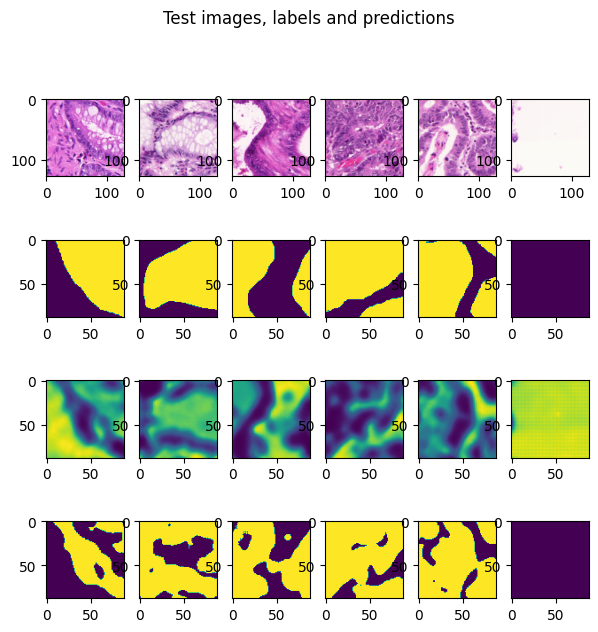

In [25]:
evaluate(model, gland_test_data)

In [26]:
torch.save(model, 'results/model20pct_data.pt')

In [27]:
ensemble_size = 4 # num models in ensemble
min_samples = 20  # min size dataset to train on

ensemble_models = []
for _ in range(ensemble_size):

    # get random data points
    random_subset_idx = np.random.permutation(labeled_idx)[:np.random.randint(min_samples, len(labeled_idx))]
    random_subset_data = GlandData(datadir + 'train/train_', random_subset_idx)

    # train model
    model, epoch_losses, batch_losses = train_unet_128(random_subset_data, nr_epochs=300)
    ensemble_models.append(model)

  1%|█▎                                                                                             | 4/300 [00:00<00:18, 16.36it/s]

Epoch 3/300, loss 0.6932033850596502

  3%|██▌                                                                                            | 8/300 [00:00<00:17, 16.55it/s]

Epoch 7/300, loss 0.6929123539191026

  4%|███▊                                                                                          | 12/300 [00:00<00:17, 16.62it/s]

Epoch 11/300, loss 0.6929199374639071

  5%|█████                                                                                         | 16/300 [00:00<00:17, 16.65it/s]

Epoch 15/300, loss 0.6927173045965341

  7%|██████▎                                                                                       | 20/300 [00:01<00:17, 16.46it/s]

Epoch 19/300, loss 0.6928897545887873

  8%|███████▌                                                                                      | 24/300 [00:01<00:16, 16.65it/s]

Epoch 23/300, loss 0.6927026556088374

  9%|████████▊                                                                                     | 28/300 [00:01<00:16, 16.78it/s]

Epoch 27/300, loss 0.6915710201630225

 11%|██████████                                                                                    | 32/300 [00:01<00:16, 16.62it/s]

Epoch 31/300, loss 0.6903377908926743

 12%|███████████▎                                                                                  | 36/300 [00:02<00:15, 16.52it/s]

Epoch 35/300, loss 0.6886964486195497

 13%|████████████▌                                                                                 | 40/300 [00:02<00:15, 16.36it/s]

Epoch 39/300, loss 0.6788331820414617

 15%|█████████████▊                                                                                | 44/300 [00:02<00:15, 16.43it/s]

Epoch 43/300, loss 0.6289733923398532

 16%|███████████████                                                                               | 48/300 [00:02<00:15, 15.90it/s]

Epoch 47/300, loss 0.6227558346895071

 17%|████████████████▎                                                                             | 52/300 [00:03<00:15, 15.64it/s]

Epoch 51/300, loss 0.6153119619076068

 19%|█████████████████▌                                                                            | 56/300 [00:03<00:15, 15.51it/s]

Epoch 55/300, loss 0.6027388022496153

 20%|██████████████████▊                                                                           | 60/300 [00:03<00:15, 15.40it/s]

Epoch 59/300, loss 0.5975160231957068

 21%|████████████████████                                                                          | 64/300 [00:03<00:15, 15.28it/s]

Epoch 63/300, loss 0.5920917391777039

 23%|█████████████████████▎                                                                        | 68/300 [00:04<00:15, 15.22it/s]

Epoch 67/300, loss 0.5941514281126169

 24%|██████████████████████▌                                                                       | 72/300 [00:04<00:14, 15.31it/s]

Epoch 71/300, loss 0.6037432276285611

 25%|███████████████████████▊                                                                      | 76/300 [00:04<00:14, 15.29it/s]

Epoch 75/300, loss 0.5844975801614615

 27%|█████████████████████████                                                                     | 80/300 [00:05<00:14, 15.31it/s]

Epoch 79/300, loss 0.5853721591142508

 28%|██████████████████████████▎                                                                   | 84/300 [00:05<00:14, 15.28it/s]

Epoch 83/300, loss 0.5916768427078544

 29%|███████████████████████████▌                                                                  | 88/300 [00:05<00:13, 15.21it/s]

Epoch 87/300, loss 0.5843046238789191

 31%|████████████████████████████▊                                                                 | 92/300 [00:05<00:13, 15.19it/s]

Epoch 91/300, loss 0.5874289457614605

 32%|██████████████████████████████                                                                | 96/300 [00:06<00:13, 15.12it/s]

Epoch 95/300, loss 0.5807257500978616

 33%|███████████████████████████████                                                              | 100/300 [00:06<00:13, 15.32it/s]

Epoch 99/300, loss 0.5798766452532548

 35%|████████████████████████████████▏                                                            | 104/300 [00:06<00:12, 15.77it/s]

Epoch 103/300, loss 0.5776679745087256

 36%|█████████████████████████████████▍                                                           | 108/300 [00:06<00:11, 16.06it/s]

Epoch 107/300, loss 0.5829334121484023

 37%|██████████████████████████████████▋                                                          | 112/300 [00:07<00:11, 16.10it/s]

Epoch 111/300, loss 0.5817198799206664

 39%|███████████████████████████████████▉                                                         | 116/300 [00:07<00:11, 15.96it/s]

Epoch 115/300, loss 0.5825612178215613

 40%|█████████████████████████████████████▏                                                       | 120/300 [00:07<00:11, 16.11it/s]

Epoch 119/300, loss 0.5695794018415304

 41%|██████████████████████████████████████▍                                                      | 124/300 [00:07<00:10, 16.32it/s]

Epoch 123/300, loss 0.5756164835049555

 43%|███████████████████████████████████████▋                                                     | 128/300 [00:08<00:10, 16.38it/s]

Epoch 127/300, loss 0.5844350686440101

 44%|████████████████████████████████████████▉                                                    | 132/300 [00:08<00:10, 16.43it/s]

Epoch 131/300, loss 0.5810083448886871

 45%|██████████████████████████████████████████▏                                                  | 136/300 [00:08<00:10, 16.34it/s]

Epoch 135/300, loss 0.5802707442870507

 47%|███████████████████████████████████████████▍                                                 | 140/300 [00:08<00:09, 16.34it/s]

Epoch 139/300, loss 0.5776804410494291

 47%|████████████████████████████████████████████                                                 | 142/300 [00:08<00:09, 16.21it/s]

Epoch 142/300, loss 0.5724026446159078

 49%|█████████████████████████████████████████████▎                                               | 146/300 [00:09<00:10, 15.26it/s]

Epoch 146/300, loss 0.5743398162034842

 50%|██████████████████████████████████████████████▌                                              | 150/300 [00:09<00:09, 15.57it/s]

Epoch 150/300, loss 0.5706038658435528

 51%|███████████████████████████████████████████████▋                                             | 154/300 [00:09<00:09, 15.72it/s]

Epoch 154/300, loss 0.5708826803244077

 53%|████████████████████████████████████████████████▉                                            | 158/300 [00:09<00:08, 15.91it/s]

Epoch 158/300, loss 0.5813572429693662

 54%|██████████████████████████████████████████████████▏                                          | 162/300 [00:10<00:08, 16.18it/s]

Epoch 162/300, loss 0.5745199414399954

 55%|███████████████████████████████████████████████████▍                                         | 166/300 [00:10<00:08, 16.21it/s]

Epoch 166/300, loss 0.5706840547231528

 57%|████████████████████████████████████████████████████▋                                        | 170/300 [00:10<00:07, 16.29it/s]

Epoch 170/300, loss 0.5734319709814512

 58%|█████████████████████████████████████████████████████▉                                       | 174/300 [00:10<00:07, 16.41it/s]

Epoch 174/300, loss 0.5770149918702933

 59%|███████████████████████████████████████████████████████▏                                     | 178/300 [00:11<00:07, 16.48it/s]

Epoch 178/300, loss 0.5695515618874476

 61%|████████████████████████████████████████████████████████▍                                    | 182/300 [00:11<00:07, 16.35it/s]

Epoch 182/300, loss 0.5667352057420291

 62%|█████████████████████████████████████████████████████████▋                                   | 186/300 [00:11<00:07, 16.20it/s]

Epoch 186/300, loss 0.5676547518143287

 63%|██████████████████████████████████████████████████████████▉                                  | 190/300 [00:11<00:06, 15.96it/s]

Epoch 190/300, loss 0.5656481820803422

 65%|████████████████████████████████████████████████████████████▏                                | 194/300 [00:12<00:06, 16.00it/s]

Epoch 194/300, loss 0.5573419470053452

 66%|█████████████████████████████████████████████████████████████▍                               | 198/300 [00:12<00:06, 15.95it/s]

Epoch 198/300, loss 0.5563871287382566

 67%|██████████████████████████████████████████████████████████████▌                              | 202/300 [00:12<00:06, 15.85it/s]

Epoch 202/300, loss 0.5595171382794013

 69%|███████████████████████████████████████████████████████████████▊                             | 206/300 [00:12<00:05, 15.87it/s]

Epoch 206/300, loss 0.5590372589918283

 70%|█████████████████████████████████████████████████████████████████                            | 210/300 [00:13<00:05, 15.96it/s]

Epoch 210/300, loss 0.5502714560582087

 71%|██████████████████████████████████████████████████████████████████▎                          | 214/300 [00:13<00:05, 15.90it/s]

Epoch 214/300, loss 0.5609696645003098

 73%|███████████████████████████████████████████████████████████████████▌                         | 218/300 [00:13<00:05, 15.75it/s]

Epoch 218/300, loss 0.5515190202456254

 74%|████████████████████████████████████████████████████████████████████▊                        | 222/300 [00:13<00:04, 15.93it/s]

Epoch 222/300, loss 0.5567474594483008

 75%|██████████████████████████████████████████████████████████████████████                       | 226/300 [00:14<00:04, 16.25it/s]

Epoch 226/300, loss 0.5510382354259491

 77%|███████████████████████████████████████████████████████████████████████▎                     | 230/300 [00:14<00:04, 16.21it/s]

Epoch 230/300, loss 0.5480380837733929

 78%|████████████████████████████████████████████████████████████████████████▌                    | 234/300 [00:14<00:04, 16.00it/s]

Epoch 234/300, loss 0.5534805174057305

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 238/300 [00:14<00:03, 15.80it/s]

Epoch 238/300, loss 0.5433816313743591

 81%|███████████████████████████████████████████████████████████████████████████                  | 242/300 [00:15<00:03, 15.78it/s]

Epoch 242/300, loss 0.5502463143605453

 82%|████████████████████████████████████████████████████████████████████████████▎                | 246/300 [00:15<00:03, 16.06it/s]

Epoch 246/300, loss 0.5449611911406884

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 250/300 [00:15<00:03, 16.30it/s]

Epoch 250/300, loss 0.5431907704243293

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 254/300 [00:15<00:02, 16.51it/s]

Epoch 254/300, loss 0.5462391674518585

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 258/300 [00:16<00:02, 16.64it/s]

Epoch 258/300, loss 0.5411313772201538

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 262/300 [00:16<00:02, 16.53it/s]

Epoch 262/300, loss 0.5411700652195857

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 266/300 [00:16<00:02, 16.56it/s]

Epoch 266/300, loss 0.5383591239268963

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 270/300 [00:16<00:01, 16.47it/s]

Epoch 270/300, loss 0.5381469634863046

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 274/300 [00:17<00:01, 15.95it/s]

Epoch 274/300, loss 0.5366891186970931

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 278/300 [00:17<00:01, 16.07it/s]

Epoch 278/300, loss 0.5329100145743444

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 282/300 [00:17<00:01, 16.42it/s]

Epoch 282/300, loss 0.5305569561628195

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 286/300 [00:17<00:00, 16.56it/s]

Epoch 286/300, loss 0.5272979438304901

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 290/300 [00:18<00:00, 16.56it/s]

Epoch 290/300, loss 0.5302537771371695

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 294/300 [00:18<00:00, 16.50it/s]

Epoch 294/300, loss 0.5262912465975835

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 298/300 [00:18<00:00, 16.43it/s]

Epoch 298/300, loss 0.5220320752033825

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:18<00:00, 16.03it/s]


Epoch 299/300, loss 0.5309662016538473

  0%|                                                                                                       | 0/300 [00:00<?, ?it/s]

Epoch 0/300, loss 0.6987789154052735

  1%|▉                                                                                              | 3/300 [00:00<00:13, 21.62it/s]

Epoch 4/300, loss 0.6978627562522888

  2%|█▉                                                                                             | 6/300 [00:00<00:13, 21.35it/s]

Epoch 5/300, loss 0.6984620153903961

  3%|██▊                                                                                            | 9/300 [00:00<00:13, 21.54it/s]

Epoch 10/300, loss 0.6978336572647095

  5%|████▋                                                                                         | 15/300 [00:00<00:13, 21.65it/s]

Epoch 15/300, loss 0.6944667994976044

  6%|█████▋                                                                                        | 18/300 [00:00<00:13, 21.27it/s]

Epoch 19/300, loss 0.6933001577854156

  7%|██████▌                                                                                       | 21/300 [00:00<00:13, 21.30it/s]

Epoch 20/300, loss 0.692964506149292

  8%|███████▌                                                                                      | 24/300 [00:01<00:12, 21.42it/s]

Epoch 25/300, loss 0.6923954606056213

 10%|█████████▍                                                                                    | 30/300 [00:01<00:12, 21.33it/s]

Epoch 30/300, loss 0.6914439558982849

 11%|██████████▎                                                                                   | 33/300 [00:01<00:12, 21.29it/s]

Epoch 34/300, loss 0.6901385247707367

 12%|███████████▎                                                                                  | 36/300 [00:01<00:12, 21.42it/s]

Epoch 35/300, loss 0.6896182596683502

 13%|████████████▏                                                                                 | 39/300 [00:01<00:12, 21.51it/s]

Epoch 40/300, loss 0.6858366191387176

 15%|██████████████                                                                                | 45/300 [00:02<00:11, 21.43it/s]

Epoch 45/300, loss 0.6642376720905304

 16%|███████████████                                                                               | 48/300 [00:02<00:11, 21.39it/s]

Epoch 49/300, loss 0.6604651153087616

 17%|███████████████▉                                                                              | 51/300 [00:02<00:11, 21.46it/s]

Epoch 50/300, loss 0.6619622886180878

 18%|████████████████▉                                                                             | 54/300 [00:02<00:11, 21.54it/s]

Epoch 55/300, loss 0.6468355596065521

 20%|██████████████████▊                                                                           | 60/300 [00:02<00:11, 21.36it/s]

Epoch 60/300, loss 0.6486421346664428

 21%|███████████████████▋                                                                          | 63/300 [00:02<00:11, 21.14it/s]

Epoch 64/300, loss 0.6410471081733704

 22%|████████████████████▋                                                                         | 66/300 [00:03<00:11, 20.92it/s]

Epoch 65/300, loss 0.6379208505153656

 23%|█████████████████████▌                                                                        | 69/300 [00:03<00:11, 20.78it/s]

Epoch 70/300, loss 0.6304156124591828

 25%|███████████████████████▌                                                                      | 75/300 [00:03<00:10, 20.53it/s]

Epoch 75/300, loss 0.6238832890987396

 26%|████████████████████████▍                                                                     | 78/300 [00:03<00:10, 20.62it/s]

Epoch 79/300, loss 0.6174345433712005

 27%|█████████████████████████▍                                                                    | 81/300 [00:03<00:10, 20.86it/s]

Epoch 80/300, loss 0.6170669317245483

 28%|██████████████████████████▎                                                                   | 84/300 [00:03<00:10, 21.00it/s]

Epoch 85/300, loss 0.6110152184963227

 30%|████████████████████████████▏                                                                 | 90/300 [00:04<00:10, 20.88it/s]

Epoch 90/300, loss 0.6077599525451667

 31%|█████████████████████████████▏                                                                | 93/300 [00:04<00:09, 21.02it/s]

Epoch 94/300, loss 0.6111471295356751

 32%|██████████████████████████████                                                                | 96/300 [00:04<00:09, 21.19it/s]

Epoch 95/300, loss 0.6095672249794006

 33%|███████████████████████████████                                                               | 99/300 [00:04<00:09, 21.35it/s]

Epoch 100/300, loss 0.5978999257087707

 35%|████████████████████████████████▌                                                            | 105/300 [00:04<00:09, 21.47it/s]

Epoch 105/300, loss 0.5918538749217988

 36%|█████████████████████████████████▍                                                           | 108/300 [00:05<00:09, 21.21it/s]

Epoch 109/300, loss 0.6162052869796752

 37%|██████████████████████████████████▍                                                          | 111/300 [00:05<00:08, 21.26it/s]

Epoch 110/300, loss 0.6258662581443787

 38%|███████████████████████████████████▎                                                         | 114/300 [00:05<00:08, 21.42it/s]

Epoch 115/300, loss 0.5933315724134445

 40%|█████████████████████████████████████▏                                                       | 120/300 [00:05<00:08, 21.56it/s]

Epoch 120/300, loss 0.5901354014873504

 41%|██████████████████████████████████████▏                                                      | 123/300 [00:05<00:08, 21.24it/s]

Epoch 124/300, loss 0.5815815806388855

 42%|███████████████████████████████████████                                                      | 126/300 [00:05<00:08, 21.17it/s]

Epoch 125/300, loss 0.5832262158393859

 43%|███████████████████████████████████████▉                                                     | 129/300 [00:06<00:08, 21.22it/s]

Epoch 130/300, loss 0.5884903669357318

 45%|█████████████████████████████████████████▊                                                   | 135/300 [00:06<00:07, 21.32it/s]

Epoch 135/300, loss 0.5862783849239349

 46%|██████████████████████████████████████████▊                                                  | 138/300 [00:06<00:07, 21.07it/s]

Epoch 139/300, loss 0.5797332227230072

 47%|███████████████████████████████████████████▋                                                 | 141/300 [00:06<00:07, 21.11it/s]

Epoch 140/300, loss 0.5620915710926055

 48%|████████████████████████████████████████████▋                                                | 144/300 [00:06<00:07, 21.20it/s]

Epoch 145/300, loss 0.5639423608779908

 50%|██████████████████████████████████████████████▌                                              | 150/300 [00:07<00:07, 21.43it/s]

Epoch 150/300, loss 0.5648459017276763

 51%|███████████████████████████████████████████████▍                                             | 153/300 [00:07<00:06, 21.48it/s]

Epoch 154/300, loss 0.5608525812625885

 52%|████████████████████████████████████████████████▎                                            | 156/300 [00:07<00:06, 21.59it/s]

Epoch 155/300, loss 0.5655728846788406

 53%|█████████████████████████████████████████████████▎                                           | 159/300 [00:07<00:06, 21.61it/s]

Epoch 160/300, loss 0.5538350582122803

 55%|███████████████████████████████████████████████████▏                                         | 165/300 [00:07<00:06, 21.59it/s]

Epoch 165/300, loss 0.5766628146171574

 56%|████████████████████████████████████████████████████                                         | 168/300 [00:07<00:06, 21.14it/s]

Epoch 169/300, loss 0.5543837755918503

 57%|█████████████████████████████████████████████████████                                        | 171/300 [00:08<00:06, 21.16it/s]

Epoch 170/300, loss 0.5385213524103165

 58%|█████████████████████████████████████████████████████▉                                       | 174/300 [00:08<00:05, 21.24it/s]

Epoch 175/300, loss 0.5279780626296997

 60%|███████████████████████████████████████████████████████▊                                     | 180/300 [00:08<00:05, 21.40it/s]

Epoch 180/300, loss 0.5607630521059036

 61%|████████████████████████████████████████████████████████▋                                    | 183/300 [00:08<00:05, 21.10it/s]

Epoch 184/300, loss 0.5515206396579743

 62%|█████████████████████████████████████████████████████████▋                                   | 186/300 [00:08<00:05, 21.13it/s]

Epoch 185/300, loss 0.5400661051273346

 63%|██████████████████████████████████████████████████████████▌                                  | 189/300 [00:08<00:05, 21.25it/s]

Epoch 190/300, loss 0.5239394873380661

 65%|████████████████████████████████████████████████████████████▍                                | 195/300 [00:09<00:04, 21.35it/s]

Epoch 195/300, loss 0.5299831151962288

 66%|█████████████████████████████████████████████████████████████▍                               | 198/300 [00:09<00:04, 21.31it/s]

Epoch 199/300, loss 0.5071560978889466

 67%|██████████████████████████████████████████████████████████████▎                              | 201/300 [00:09<00:04, 21.06it/s]

Epoch 200/300, loss 0.5165695071220398

 68%|███████████████████████████████████████████████████████████████▏                             | 204/300 [00:09<00:04, 21.26it/s]

Epoch 205/300, loss 0.5403453618288047

 70%|█████████████████████████████████████████████████████████████████                            | 210/300 [00:09<00:04, 21.47it/s]

Epoch 210/300, loss 0.5497662395238876

 71%|██████████████████████████████████████████████████████████████████                           | 213/300 [00:10<00:04, 21.45it/s]

Epoch 214/300, loss 0.5413772493600846

 72%|██████████████████████████████████████████████████████████████████▉                          | 216/300 [00:10<00:03, 21.13it/s]

Epoch 215/300, loss 0.5219348460435868

 73%|███████████████████████████████████████████████████████████████████▉                         | 219/300 [00:10<00:03, 21.20it/s]

Epoch 220/300, loss 0.5174126207828522

 75%|█████████████████████████████████████████████████████████████████████▊                       | 225/300 [00:10<00:03, 21.49it/s]

Epoch 225/300, loss 0.49745622277259827

 76%|██████████████████████████████████████████████████████████████████████▋                      | 228/300 [00:10<00:03, 21.55it/s]

Epoch 229/300, loss 0.5307572960853577

 77%|███████████████████████████████████████████████████████████████████████▌                     | 231/300 [00:10<00:03, 21.61it/s]

Epoch 230/300, loss 0.516775244474411

 78%|████████████████████████████████████████████████████████████████████████▌                    | 234/300 [00:10<00:03, 21.65it/s]

Epoch 235/300, loss 0.48129796981811523

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 237/300 [00:11<00:02, 21.34it/s]

Epoch 238/300, loss 0.49551169574260714

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 240/300 [00:11<00:02, 20.83it/s]

Epoch 239/300, loss 0.49531819224357604

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 243/300 [00:11<00:02, 20.60it/s]

Epoch 243/300, loss 0.5158740013837815

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 249/300 [00:11<00:02, 20.15it/s]

Epoch 248/300, loss 0.4956720769405365

 84%|██████████████████████████████████████████████████████████████████████████████               | 252/300 [00:11<00:02, 19.91it/s]

Epoch 252/300, loss 0.4886013329029083

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 256/300 [00:12<00:02, 19.30it/s]

Epoch 256/300, loss 0.4920252859592438

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 260/300 [00:12<00:02, 19.05it/s]

Epoch 260/300, loss 0.48233293294906615

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 264/300 [00:12<00:01, 18.34it/s]

Epoch 264/300, loss 0.51463217437267317

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 267/300 [00:12<00:01, 18.48it/s]

Epoch 268/300, loss 0.5399185091257095

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 272/300 [00:12<00:01, 19.10it/s]

Epoch 272/300, loss 0.50719288885593423

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 276/300 [00:13<00:01, 18.55it/s]

Epoch 276/300, loss 0.51076090037822724

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 280/300 [00:13<00:01, 18.88it/s]

Epoch 280/300, loss 0.5218049854040145

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 284/300 [00:13<00:00, 18.48it/s]

Epoch 284/300, loss 0.4882377862930298

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 288/300 [00:13<00:00, 18.44it/s]

Epoch 288/300, loss 0.5084045976400375

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 292/300 [00:14<00:00, 18.52it/s]

Epoch 292/300, loss 0.4842560261487961

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 296/300 [00:14<00:00, 18.75it/s]

Epoch 296/300, loss 0.49067960977554324

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.74it/s]

Epoch 299/300, loss 0.46881268024444585


  1%|█▎                                                                                             | 4/300 [00:00<00:19, 15.25it/s]

Epoch 3/300, loss 0.6921302591051374

  3%|██▌                                                                                            | 8/300 [00:00<00:18, 15.49it/s]

Epoch 7/300, loss 0.6922950616904667

  3%|███▏                                                                                          | 10/300 [00:00<00:18, 15.54it/s]

Epoch 10/300, loss 0.6916145767484393

  5%|████▍                                                                                         | 14/300 [00:00<00:19, 14.48it/s]

Epoch 13/300, loss 0.6913176178932196

  6%|█████▋                                                                                        | 18/300 [00:01<00:19, 14.53it/s]

Epoch 17/300, loss 0.6907125072819846

  7%|██████▎                                                                                       | 20/300 [00:01<00:19, 14.48it/s]

Epoch 20/300, loss 0.6897275107247489

  8%|███████▌                                                                                      | 24/300 [00:01<00:19, 14.40it/s]

Epoch 23/300, loss 0.6893988421985081

  9%|████████▊                                                                                     | 28/300 [00:01<00:18, 14.82it/s]

Epoch 27/300, loss 0.6889611780643463

 11%|██████████                                                                                    | 32/300 [00:02<00:17, 14.98it/s]

Epoch 31/300, loss 0.6885669018541064

 12%|███████████▎                                                                                  | 36/300 [00:02<00:17, 15.08it/s]

Epoch 35/300, loss 0.6876238669667926

 13%|████████████▌                                                                                 | 40/300 [00:02<00:17, 15.26it/s]

Epoch 39/300, loss 0.6872183169637408

 15%|█████████████▊                                                                                | 44/300 [00:02<00:16, 15.10it/s]

Epoch 43/300, loss 0.6827108902590615

 15%|██████████████▍                                                                               | 46/300 [00:03<00:16, 14.95it/s]

Epoch 46/300, loss 0.6687367047582354

 17%|███████████████▋                                                                              | 50/300 [00:03<00:17, 14.64it/s]

Epoch 49/300, loss 0.6565818147999922

 17%|████████████████▎                                                                             | 52/300 [00:03<00:16, 14.61it/s]

Epoch 52/300, loss 0.6534899898937776

 19%|█████████████████▌                                                                            | 56/300 [00:03<00:16, 14.47it/s]

Epoch 55/300, loss 0.6457540180001949

 19%|██████████████████▏                                                                           | 58/300 [00:03<00:16, 14.43it/s]

Epoch 58/300, loss 0.6411054815564837

 21%|███████████████████▍                                                                          | 62/300 [00:04<00:16, 14.38it/s]

Epoch 61/300, loss 0.6449873404843467

 21%|████████████████████                                                                          | 64/300 [00:04<00:16, 14.37it/s]

Epoch 64/300, loss 0.6344835375036512

 23%|█████████████████████▎                                                                        | 68/300 [00:04<00:16, 14.47it/s]

Epoch 68/300, loss 0.6301676971571786

 24%|██████████████████████▌                                                                       | 72/300 [00:04<00:15, 14.64it/s]

Epoch 71/300, loss 0.6279168767588479

 25%|███████████████████████▊                                                                      | 76/300 [00:05<00:14, 14.96it/s]

Epoch 75/300, loss 0.6271029370171683

 27%|█████████████████████████                                                                     | 80/300 [00:05<00:14, 15.22it/s]

Epoch 79/300, loss 0.6275541441781181

 28%|██████████████████████████▎                                                                   | 84/300 [00:05<00:14, 15.37it/s]

Epoch 83/300, loss 0.6197885274887085

 29%|███████████████████████████▌                                                                  | 88/300 [00:05<00:13, 15.38it/s]

Epoch 87/300, loss 0.6160442701407841

 31%|████████████████████████████▊                                                                 | 92/300 [00:06<00:13, 15.21it/s]

Epoch 91/300, loss 0.6142053008079529

 32%|██████████████████████████████                                                                | 96/300 [00:06<00:13, 15.34it/s]

Epoch 95/300, loss 0.6078352161816188

 33%|███████████████████████████████                                                              | 100/300 [00:06<00:13, 15.18it/s]

Epoch 99/300, loss 0.5999348206179482

 34%|███████████████████████████████▌                                                             | 102/300 [00:06<00:13, 15.00it/s]

Epoch 102/300, loss 0.5900875202247075

 35%|████████████████████████████████▊                                                            | 106/300 [00:07<00:12, 15.01it/s]

Epoch 106/300, loss 0.5882655871765954

 37%|██████████████████████████████████                                                           | 110/300 [00:07<00:12, 15.16it/s]

Epoch 110/300, loss 0.5962143029485439

 38%|███████████████████████████████████▎                                                         | 114/300 [00:07<00:12, 15.22it/s]

Epoch 114/300, loss 0.5698039723294122

 39%|████████████████████████████████████▌                                                        | 118/300 [00:07<00:11, 15.17it/s]

Epoch 117/300, loss 0.5570217200687954

 41%|█████████████████████████████████████▊                                                       | 122/300 [00:08<00:11, 15.10it/s]

Epoch 121/300, loss 0.5544545671769551

 41%|██████████████████████████████████████▍                                                      | 124/300 [00:08<00:11, 15.05it/s]

Epoch 124/300, loss 0.5649118210588183

 43%|███████████████████████████████████████▋                                                     | 128/300 [00:08<00:11, 14.48it/s]

Epoch 127/300, loss 0.5479328164032528

 43%|████████████████████████████████████████▎                                                    | 130/300 [00:08<00:11, 14.35it/s]

Epoch 130/300, loss 0.5505820342472622

 45%|█████████████████████████████████████████▌                                                   | 134/300 [00:09<00:11, 14.14it/s]

Epoch 133/300, loss 0.5479989605290554

 45%|██████████████████████████████████████████▏                                                  | 136/300 [00:09<00:11, 14.14it/s]

Epoch 136/300, loss 0.5573344933135169

 47%|███████████████████████████████████████████▍                                                 | 140/300 [00:09<00:11, 14.01it/s]

Epoch 139/300, loss 0.5518223494291306

 47%|████████████████████████████████████████████                                                 | 142/300 [00:09<00:11, 14.02it/s]

Epoch 142/300, loss 0.5300556336130414

 49%|█████████████████████████████████████████████▎                                               | 146/300 [00:09<00:11, 13.97it/s]

Epoch 145/300, loss 0.5268697653497968

 49%|█████████████████████████████████████████████▉                                               | 148/300 [00:10<00:10, 13.91it/s]

Epoch 148/300, loss 0.5427323430776596

 51%|███████████████████████████████████████████████                                              | 152/300 [00:10<00:10, 13.92it/s]

Epoch 151/300, loss 0.5498734414577484

 51%|███████████████████████████████████████████████▋                                             | 154/300 [00:10<00:10, 13.94it/s]

Epoch 154/300, loss 0.5288350411823818

 53%|████████████████████████████████████████████████▉                                            | 158/300 [00:10<00:09, 14.43it/s]

Epoch 157/300, loss 0.5451952453170504

 53%|█████████████████████████████████████████████████▌                                           | 160/300 [00:10<00:09, 14.54it/s]

Epoch 160/300, loss 0.5316450659717832

 55%|██████████████████████████████████████████████████▊                                          | 164/300 [00:11<00:09, 14.41it/s]

Epoch 163/300, loss 0.5282631111996514

 55%|███████████████████████████████████████████████████▍                                         | 166/300 [00:11<00:09, 14.44it/s]

Epoch 166/300, loss 0.5327109375170299

 57%|████████████████████████████████████████████████████▋                                        | 170/300 [00:11<00:08, 14.49it/s]

Epoch 169/300, loss 0.5235673487186432

 58%|█████████████████████████████████████████████████████▉                                       | 174/300 [00:11<00:08, 14.89it/s]

Epoch 173/300, loss 0.5315197833946773

 59%|███████████████████████████████████████████████████████▏                                     | 178/300 [00:12<00:07, 15.26it/s]

Epoch 177/300, loss 0.5226589228425708

 61%|████████████████████████████████████████████████████████▍                                    | 182/300 [00:12<00:07, 15.46it/s]

Epoch 181/300, loss 0.5223495406763894

 62%|█████████████████████████████████████████████████████████▋                                   | 186/300 [00:12<00:07, 15.49it/s]

Epoch 185/300, loss 0.5301504858902523

 63%|██████████████████████████████████████████████████████████▎                                  | 188/300 [00:12<00:07, 15.18it/s]

Epoch 188/300, loss 0.5250620671680996

 64%|███████████████████████████████████████████████████████████▌                                 | 192/300 [00:13<00:07, 14.81it/s]

Epoch 191/300, loss 0.5196132617337363

 65%|████████████████████████████████████████████████████████████▊                                | 196/300 [00:13<00:07, 14.76it/s]

Epoch 195/300, loss 0.5143947920628956

 66%|█████████████████████████████████████████████████████████████▍                               | 198/300 [00:13<00:06, 14.74it/s]

Epoch 198/300, loss 0.5165722774607795

 67%|██████████████████████████████████████████████████████████████▌                              | 202/300 [00:13<00:06, 14.48it/s]

Epoch 201/300, loss 0.5215675341231483

 69%|███████████████████████████████████████████████████████████████▊                             | 206/300 [00:13<00:06, 14.74it/s]

Epoch 205/300, loss 0.5152851407017026

 70%|█████████████████████████████████████████████████████████████████                            | 210/300 [00:14<00:06, 14.93it/s]

Epoch 209/300, loss 0.5205594897270203

 71%|██████████████████████████████████████████████████████████████████▎                          | 214/300 [00:14<00:05, 14.97it/s]

Epoch 213/300, loss 0.5223191274063927

 73%|███████████████████████████████████████████████████████████████████▌                         | 218/300 [00:14<00:05, 15.16it/s]

Epoch 217/300, loss 0.5262613296508789

 73%|████████████████████████████████████████████████████████████████████▏                        | 220/300 [00:14<00:05, 14.92it/s]

Epoch 220/300, loss 0.5104663712637765

 75%|█████████████████████████████████████████████████████████████████████▍                       | 224/300 [00:15<00:05, 14.84it/s]

Epoch 223/300, loss 0.5158681273460388

 75%|██████████████████████████████████████████████████████████████████████                       | 226/300 [00:15<00:04, 14.91it/s]

Epoch 226/300, loss 0.5179058483668736

 77%|███████████████████████████████████████████████████████████████████████▎                     | 230/300 [00:15<00:04, 14.31it/s]

Epoch 229/300, loss 0.5119374862739018

 77%|███████████████████████████████████████████████████████████████████████▉                     | 232/300 [00:15<00:04, 14.17it/s]

Epoch 232/300, loss 0.5129045950514933

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 236/300 [00:16<00:04, 14.06it/s]

Epoch 235/300, loss 0.5339224232094628

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 238/300 [00:16<00:04, 14.07it/s]

Epoch 238/300, loss 0.5247840689761298

 81%|███████████████████████████████████████████████████████████████████████████                  | 242/300 [00:16<00:04, 13.95it/s]

Epoch 241/300, loss 0.5096782743930817

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 244/300 [00:16<00:04, 13.87it/s]

Epoch 244/300, loss 0.5080333564962659

 83%|████████████████████████████████████████████████████████████████████████████▉                | 248/300 [00:16<00:03, 13.83it/s]

Epoch 247/300, loss 0.5221439663852964

 84%|██████████████████████████████████████████████████████████████████████████████               | 252/300 [00:17<00:03, 14.15it/s]

Epoch 251/300, loss 0.5174831194537026

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 256/300 [00:17<00:03, 14.64it/s]

Epoch 255/300, loss 0.5098434069326946

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 258/300 [00:17<00:02, 14.54it/s]

Epoch 258/300, loss 0.5063840257269996

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 262/300 [00:17<00:02, 14.70it/s]

Epoch 262/300, loss 0.5112014625753675

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 266/300 [00:18<00:02, 14.99it/s]

Epoch 266/300, loss 0.5091475525072643

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 270/300 [00:18<00:02, 14.91it/s]

Epoch 270/300, loss 0.5033891094582421

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 274/300 [00:18<00:01, 15.07it/s]

Epoch 274/300, loss 0.5069990434816906

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 278/300 [00:18<00:01, 15.19it/s]

Epoch 277/300, loss 0.5092365358557019

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 280/300 [00:19<00:01, 14.76it/s]

Epoch 280/300, loss 0.5016663862126214

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 284/300 [00:19<00:01, 14.30it/s]

Epoch 283/300, loss 0.5101055843489519

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 286/300 [00:19<00:00, 14.16it/s]

Epoch 286/300, loss 0.5053427623850959

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 290/300 [00:19<00:00, 13.94it/s]

Epoch 289/300, loss 0.5019917786121368

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 292/300 [00:19<00:00, 13.89it/s]

Epoch 292/300, loss 0.5053442546299526

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 296/300 [00:20<00:00, 13.94it/s]

Epoch 295/300, loss 0.5011940747499466

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 298/300 [00:20<00:00, 13.97it/s]

Epoch 298/300, loss 0.5118660373347146

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:20<00:00, 14.64it/s]


Epoch 299/300, loss 0.5211634486913681

  1%|█▎                                                                                             | 4/300 [00:00<00:15, 19.09it/s]

Epoch 3/300, loss 0.7013711154460907

  3%|██▌                                                                                            | 8/300 [00:00<00:14, 19.59it/s]

Epoch 7/300, loss 0.7031606495380401

  3%|███▏                                                                                          | 10/300 [00:00<00:14, 19.66it/s]

Epoch 12/300, loss 0.6961683452129364

  6%|█████▎                                                                                        | 17/300 [00:00<00:14, 19.78it/s]

Epoch 16/300, loss 0.6971005976200104

  7%|██████▌                                                                                       | 21/300 [00:01<00:14, 19.32it/s]

Epoch 20/300, loss 0.6947611033916473

  9%|████████▏                                                                                     | 26/300 [00:01<00:13, 19.92it/s]

Epoch 25/300, loss 0.6938164949417114

 10%|█████████                                                                                     | 29/300 [00:01<00:13, 20.48it/s]

Epoch 30/300, loss 0.6927848994731903

 12%|██████████▉                                                                                   | 35/300 [00:01<00:12, 20.89it/s]

Epoch 35/300, loss 0.6920444786548614

 14%|████████████▊                                                                                 | 41/300 [00:02<00:12, 21.01it/s]

Epoch 40/300, loss 0.6929457187652588

 15%|█████████████▊                                                                                | 44/300 [00:02<00:12, 21.06it/s]

Epoch 45/300, loss 0.6926728665828705

 17%|███████████████▋                                                                              | 50/300 [00:02<00:11, 21.14it/s]

Epoch 50/300, loss 0.6924227297306068

 19%|█████████████████▌                                                                            | 56/300 [00:02<00:11, 20.62it/s]

Epoch 55/300, loss 0.6909547626972199

 20%|██████████████████▍                                                                           | 59/300 [00:02<00:11, 20.47it/s]

Epoch 60/300, loss 0.6910305440425872

 22%|████████████████████▎                                                                         | 65/300 [00:03<00:11, 20.98it/s]

Epoch 65/300, loss 0.6908252239227295

 24%|██████████████████████▏                                                                       | 71/300 [00:03<00:10, 21.11it/s]

Epoch 70/300, loss 0.6899140119552613

 25%|███████████████████████▏                                                                      | 74/300 [00:03<00:10, 21.09it/s]

Epoch 75/300, loss 0.6910791099071503

 27%|█████████████████████████                                                                     | 80/300 [00:03<00:10, 21.23it/s]

Epoch 80/300, loss 0.6892470479011535

 29%|██████████████████████████▉                                                                   | 86/300 [00:04<00:10, 21.32it/s]

Epoch 85/300, loss 0.6886267423629765

 30%|███████████████████████████▉                                                                  | 89/300 [00:04<00:09, 21.34it/s]

Epoch 90/300, loss 0.6878360748291016

 32%|█████████████████████████████▊                                                                | 95/300 [00:04<00:09, 21.45it/s]

Epoch 95/300, loss 0.6860391139984131

 34%|███████████████████████████████▎                                                             | 101/300 [00:04<00:09, 21.41it/s]

Epoch 100/300, loss 0.6840319693088531

 35%|████████████████████████████████▏                                                            | 104/300 [00:05<00:09, 20.83it/s]

Epoch 104/300, loss 0.6801136970520021

 36%|█████████████████████████████████▏                                                           | 107/300 [00:05<00:09, 20.32it/s]

Epoch 108/300, loss 0.6805001378059388

 38%|███████████████████████████████████                                                          | 113/300 [00:05<00:09, 19.93it/s]

Epoch 112/300, loss 0.6773586332798004

 39%|████████████████████████████████████▎                                                        | 117/300 [00:05<00:09, 19.56it/s]

Epoch 116/300, loss 0.6733264923095703

 40%|█████████████████████████████████████▌                                                       | 121/300 [00:05<00:09, 19.51it/s]

Epoch 120/300, loss 0.6680808007717133

 41%|██████████████████████████████████████▏                                                      | 123/300 [00:06<00:09, 19.40it/s]

Epoch 125/300, loss 0.6697458505630494

 43%|████████████████████████████████████████▎                                                    | 130/300 [00:06<00:08, 19.60it/s]

Epoch 129/300, loss 0.6666419327259063

 45%|█████████████████████████████████████████▌                                                   | 134/300 [00:06<00:08, 19.65it/s]

Epoch 133/300, loss 0.6665133714675904

 46%|███████████████████████████████████████████                                                  | 139/300 [00:06<00:08, 19.34it/s]

Epoch 138/300, loss 0.6637051880359651

 47%|████████████████████████████████████████████                                                 | 142/300 [00:06<00:07, 19.94it/s]

Epoch 143/300, loss 0.6611860096454626

 49%|█████████████████████████████████████████████▉                                               | 148/300 [00:07<00:07, 20.49it/s]

Epoch 148/300, loss 0.6596412777900695

 51%|███████████████████████████████████████████████▋                                             | 154/300 [00:07<00:07, 20.40it/s]

Epoch 153/300, loss 0.6583143472671509

 52%|████████████████████████████████████████████████▋                                            | 157/300 [00:07<00:06, 20.66it/s]

Epoch 158/300, loss 0.6563394665718079

 54%|██████████████████████████████████████████████████▌                                          | 163/300 [00:07<00:06, 20.79it/s]

Epoch 163/300, loss 0.6556576907634735

 56%|████████████████████████████████████████████████████▍                                        | 169/300 [00:08<00:06, 20.75it/s]

Epoch 168/300, loss 0.6512804806232453

 57%|█████████████████████████████████████████████████████▎                                       | 172/300 [00:08<00:06, 20.88it/s]

Epoch 173/300, loss 0.6504390597343445

 59%|███████████████████████████████████████████████████████▏                                     | 178/300 [00:08<00:05, 21.18it/s]

Epoch 178/300, loss 0.6516491711139679

 61%|█████████████████████████████████████████████████████████                                    | 184/300 [00:08<00:05, 21.55it/s]

Epoch 183/300, loss 0.6453648805618286

 62%|█████████████████████████████████████████████████████████▉                                   | 187/300 [00:09<00:05, 21.38it/s]

Epoch 188/300, loss 0.6388978123664856

 64%|███████████████████████████████████████████████████████████▊                                 | 193/300 [00:09<00:05, 21.23it/s]

Epoch 193/300, loss 0.6388982892036438

 66%|█████████████████████████████████████████████████████████████▋                               | 199/300 [00:09<00:04, 21.36it/s]

Epoch 198/300, loss 0.6338638365268707

 67%|██████████████████████████████████████████████████████████████▌                              | 202/300 [00:09<00:04, 21.36it/s]

Epoch 203/300, loss 0.6291447699069976

 69%|████████████████████████████████████████████████████████████████▍                            | 208/300 [00:10<00:04, 20.34it/s]

Epoch 207/300, loss 0.6388511657714844

 70%|█████████████████████████████████████████████████████████████████▍                           | 211/300 [00:10<00:04, 20.19it/s]

Epoch 211/300, loss 0.6282950043678284

 72%|██████████████████████████████████████████████████████████████████▉                          | 216/300 [00:10<00:04, 19.78it/s]

Epoch 215/300, loss 0.6198873698711396

 73%|████████████████████████████████████████████████████████████████████▏                        | 220/300 [00:10<00:04, 19.59it/s]

Epoch 219/300, loss 0.6097447395324707

 75%|█████████████████████████████████████████████████████████████████████▍                       | 224/300 [00:10<00:03, 19.36it/s]

Epoch 223/300, loss 0.6150321662425995

 76%|██████████████████████████████████████████████████████████████████████▎                      | 227/300 [00:11<00:03, 20.13it/s]

Epoch 228/300, loss 0.6087051272392273

 78%|████████████████████████████████████████████████████████████████████████▏                    | 233/300 [00:11<00:03, 21.03it/s]

Epoch 233/300, loss 0.5937376499176026

 80%|██████████████████████████████████████████████████████████████████████████                   | 239/300 [00:11<00:02, 20.99it/s]

Epoch 238/300, loss 0.5886124849319458

 81%|███████████████████████████████████████████████████████████████████████████                  | 242/300 [00:11<00:02, 21.12it/s]

Epoch 243/300, loss 0.5853838264942169

 83%|████████████████████████████████████████████████████████████████████████████▉                | 248/300 [00:12<00:02, 20.16it/s]

Epoch 247/300, loss 0.5802233397960663

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 251/300 [00:12<00:02, 20.14it/s]

Epoch 252/300, loss 0.5776588559150696

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 257/300 [00:12<00:02, 20.29it/s]

Epoch 257/300, loss 0.5856029748916626

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 260/300 [00:12<00:01, 20.04it/s]

Epoch 261/300, loss 0.5729365944862366

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 266/300 [00:12<00:01, 19.95it/s]

Epoch 266/300, loss 0.5724901735782624

 90%|████████████████████████████████████████████████████████████████████████████████████         | 271/300 [00:13<00:01, 20.07it/s]

Epoch 271/300, loss 0.5687379419803622

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 277/300 [00:13<00:01, 20.49it/s]

Epoch 276/300, loss 0.5629855096340179

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 280/300 [00:13<00:00, 20.69it/s]

Epoch 281/300, loss 0.5688017487525942

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 286/300 [00:13<00:00, 21.06it/s]

Epoch 286/300, loss 0.5609348058700562

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 292/300 [00:14<00:00, 21.25it/s]

Epoch 291/300, loss 0.5465417414903649

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 295/300 [00:14<00:00, 21.28it/s]

Epoch 296/300, loss 0.5671044588088989

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.54it/s]

Epoch 299/300, loss 0.5672918081283569

In [28]:
variances = []
for im, _ in unlabeled_train_data:

    im_seg = torch.zeros((4,88,88), device=device)
    for i, model in enumerate(ensemble_models):
        with torch.no_grad():
            with torch.no_grad():
                pred_logits = model(im.to(device).unsqueeze(0).to(device))
            pred = torch.nn.functional.softmax(pred_logits, dim=1)
            prob = pred[0].cpu().detach()
            seg = prob.argmax(dim=0)
            im_seg[i] = seg

    mean_var = torch.mean(torch.var(im_seg, dim=0)).cpu().item()
    variances.append(mean_var)

In [29]:
# sort the idx based on the variances
sorted_unlabeled_idx = unlabeled_idx.copy()
sorted_unlabeled_idx = sorted_unlabeled_idx[np.array(variances).argsort()]

# take the 400 most uncertain
n_uncertain = 400
uncertain_idx = sorted_unlabeled_idx[len(sorted_unlabeled_idx)-n_uncertain:len(sorted_unlabeled_idx)]

uncertain_data = GlandData(datadir + 'train/train_', uncertain_idx)
print(len(uncertain_data))

400


In [30]:
feature_vectors_labeled = torch.zeros(len(labeled_train_data), 32 * 25 * 25)
feature_vectors_unlabeled = torch.zeros(len(uncertain_data), 32 * 25 * 25)

for i, (im, _) in enumerate(labeled_train_data):
    with torch.no_grad():
        model(im.to(device).unsqueeze(0))
        feature_vectors_labeled[i] = model.bottleneck.flatten()

for i, (im, _) in enumerate(uncertain_data):
    with torch.no_grad():
        model(im.to(device).unsqueeze(0))
        feature_vectors_unlabeled[i] = model.bottleneck.flatten()

print(feature_vectors_labeled.shape)
print(feature_vectors_unlabeled.shape)

torch.Size([150, 20000])
torch.Size([400, 20000])


In [ ]:
# Step 1
import torch.nn.functional as F
cosine_similarity = F.cosine_similarity(feature_vectors_unlabeled[None,:,:], feature_vectors_unlabeled[:,None,:], dim=-1)
# cosine_similarity = F.cosine_similarity(feature_vectors_unlabeled, feature_vectors_unlabeled)
cosine_similarity.shape

In [ ]:
# Step 2 
initial_im_idx = np.random.randint(400)

# Step 3
row = cosine_similarity[:, initial_image_idx]
cosine_similarity += row.repeat(400,1).T

# Step 4
cosine_similarity[:, initial_image_idx] += 1000

# Step 5